# Progetto di Machine Learning 2023

Il presente progetto riguarda la predizione dei prezzi delle case.

In [268]:
import matplotlib.pyplot as plt
import sm as sm

from feature_selection import *
from model_selection import *
from models import *
from grafici import *
from dataset import *
import pandas as pd
import numpy as np
import seaborn as sns
from typing import List, Tuple, Dict
from pprint import pprint


In [269]:
from sklearn.model_selection import train_test_split

initial_training_set = pd.read_csv('../dataset/train.csv')

In [270]:
print(initial_training_set.shape)
print(initial_training_set.columns)

(1460, 81)
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 

Suddividiamo le colonne in numeriche e categoriche:

In [271]:
numerical_cols = initial_training_set.select_dtypes(include='number').columns.to_list()
numerical_train = initial_training_set[numerical_cols]
print(numerical_cols)

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


In [272]:
categorical_cols = initial_training_set.select_dtypes(include='object').columns.to_list()
categorical_train = initial_training_set[categorical_cols]
print(categorical_cols)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


# 1. Data Exploration

Sono state confrontate tutte le feature con il target. Per i dettagli fare riferimento ai file dataset/valutazioneFeatures.csv e valutazioneFeatures.ipynb.

## 1.1 Matrice di correlazione

Le feature più importanti sono le seguenti:

C:\Users\emeli\AppData\Local\Temp\ipykernel_8492\509050092.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = df_train.corr()


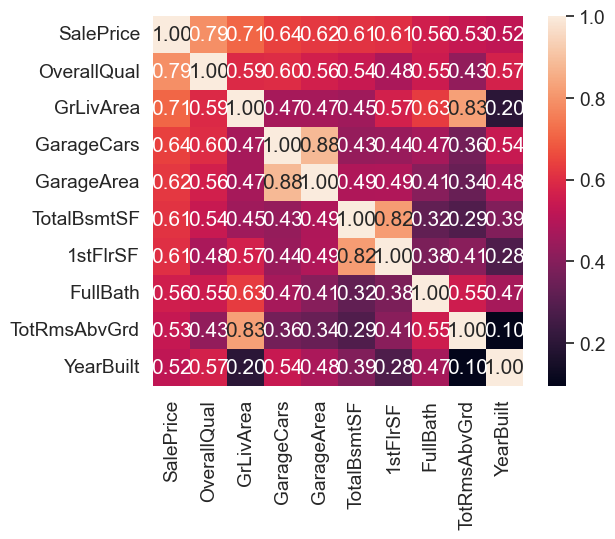

In [273]:
def correlation_matrix_plot(df_train: DataFrame, k=10):
    # saleprice correlation matrix
    corrmat = df_train.corr()
    cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
    cm = np.corrcoef(df_train[cols].values.T)
    sns.set(font_scale=1.25)
    sns.heatmap(cm,
                cbar=True,  # mostra la legenda a destra
                annot=True,  # mostra i valori nelle celle
                square=True,  # se True mostra il grafico come un quadrato
                fmt='.2f',  # formatta il numero di cifre decimali delle 'annot'
                yticklabels=cols.values,  # mostra le label dell'asse y
                xticklabels=cols.values  # mostra le label dell'asse x
                )
    plt.show()


correlation_matrix_plot(initial_training_set, k=10)

Analizziamo la heatmap:
- Sulla diagonale c'è sempre 1 perché le features sono in correlazione con loro stesse.
- La feature più importante è **OverallQual** con correlazione 0.79 rispetto al SalePrice.
- Garage Cars e Garage Area sono molto correlate tra loro, quindi si può mantenere solamente quella che è più correlata con il SalePrice, ovvero **GarageCars**.
- TotRmsAbvGrd e GrLivArea sono anche loro molto correlate tra loro, la più importante però è **GrLivArea**.
- 1stFlrSF è correlata con **TotalBsmtSF**, ma è più importante quest'ultima.

Per essere più precisi, visualizziamo la heatmap con le sole feature che hanno valore di correlazione con almeno un altra feature superiore a una certa soglia.

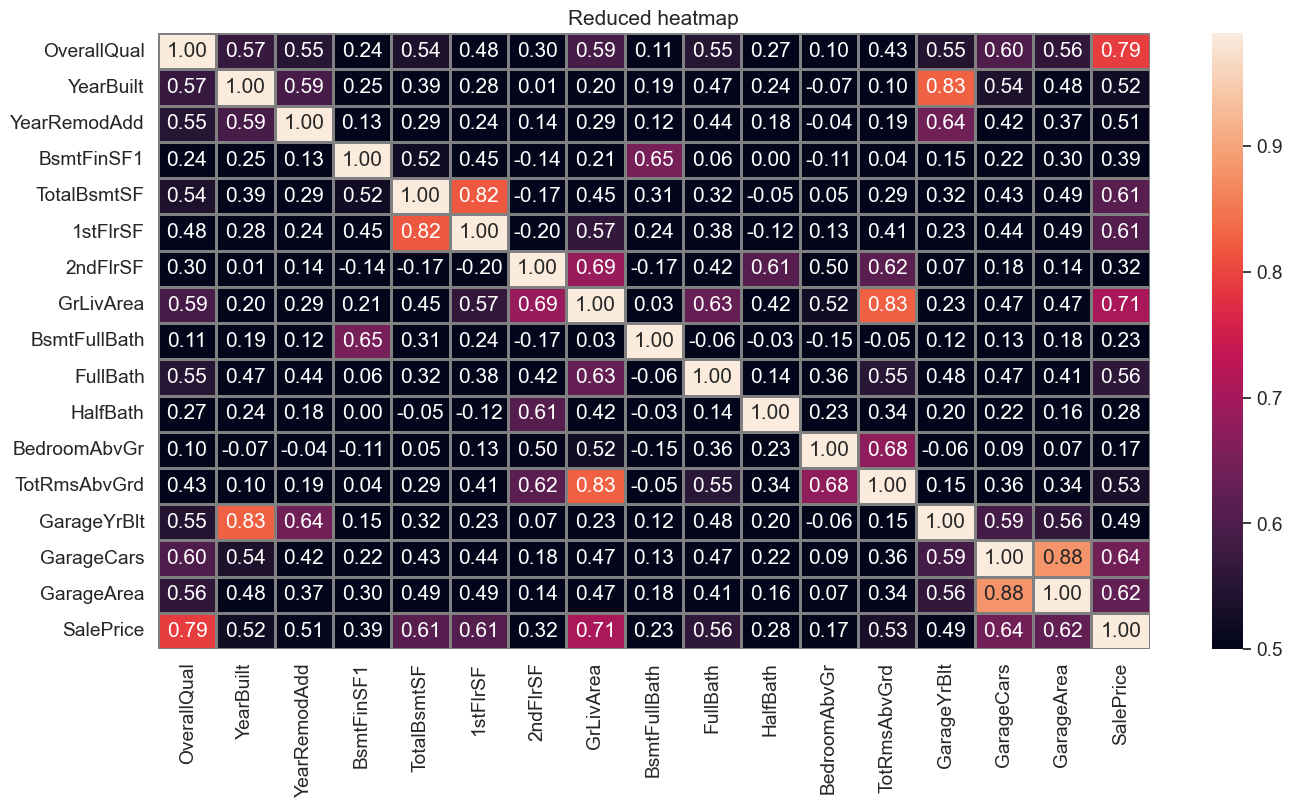

In [274]:
def correlazione_matrice(df_train: DataFrame, threshold: float, val_max: float):
    """Calcola la matrice di correlazione (ndarray) a partire da un dataframe di feature tutte numeriche"""
    corr = df_train.corr().to_numpy()
    # seleziona gli elementi che sono compresi tra il threshold e un valore massimo
    ind_x, = np.where(np.all(np.logical_or(corr < threshold, corr > val_max), axis=0))
    corr = np.delete(corr, ind_x, 1)  # si eliminano

    # stessa cosa per le righe
    ind_y, = np.where(np.all(np.logical_or(corr < threshold, corr > val_max), axis=1))
    corr = np.delete(corr, ind_y, 0)
    # si aggiornano le colonne selezionando solamente quelle filtrate

    return corr, ind_x, ind_y


def correlation_matrix_filtered_plot(df_train: DataFrame, threshold=0.6):
    # threshold: valore minimo di correlazione da considerare
    val_max = 0.99
    # si selezionano le colonne
    labels = df_train.columns
    corr, ind_x, ind_y = correlazione_matrice(df_train, threshold, val_max)
    # si aggiornano le colonne selezionando solamente quelle filtrate
    map_labels_x = [item for i, item in enumerate(labels) if i not in ind_x]
    map_labels_y = [item for i, item in enumerate(labels) if i not in ind_y]
    # plot heatmap
    plt.figure(figsize=(16, 8))
    heatmap = sns.heatmap(corr, annot=True, fmt='.2f',
                          xticklabels=map_labels_x,
                          yticklabels=map_labels_y,
                          vmin=threshold,
                          vmax=val_max,
                          linewidths=1.0,
                          linecolor="grey")

    heatmap.set_title("Reduced heatmap")
    plt.show()


correlation_matrix_filtered_plot(numerical_train, 0.5)

Ora troviamo le coppie feature con correlazione maggiore di 0.6 e prendiamo anche il valore di correlazione di ciascuna con il SalePrice:

In [275]:
def correlazione_dataframe(df_train, threshold, val_max):
    # si selezionano le colonne
    labels = df_train.columns

    corr, ind_x, ind_y = correlazione_matrice(df_train, threshold, val_max)
    map_labels_x = [item for i, item in enumerate(labels) if i not in ind_x]
    map_labels_y = [item for i, item in enumerate(labels) if i not in ind_y]

    return pd.DataFrame(corr, columns=map_labels_x, index=map_labels_y)


class Correlazione:
    def __init__(self, feature1, feature2, correlazione, correlazione_f1_target, correlazione_f2_target):
        self.feature1 = feature1
        self.feature2 = feature2
        self.correlazione = correlazione
        self.correlazione_f1_target = correlazione_f1_target
        self.correlazione_f2_target = correlazione_f2_target

    def __str__(self):
        return f"({self.feature1, self.feature2, self.correlazione, self.correlazione_f1_target, self.correlazione_f2_target})"

    def __repr__(self):
        return f"({self.feature1, self.feature2, self.correlazione, self.correlazione_f1_target, self.correlazione_f2_target})"

    def __gt__(self, other):
        return self.correlazione > other.correlazione

    def __lt__(self, other):
        return self.correlazione < other.correlazione


def feature_in_correlazione(corr: DataFrame, thresh: float) -> List[Correlazione]:
    colonne = corr.columns
    corr_list = []
    target_index = len(colonne) - 1
    # per ogni riga del dataframe della matrice di correlazione
    for (i, r) in enumerate(corr):
        # e per ogni colonna
        for (j, c) in enumerate(corr[r]):
            # se una coppia di feature diverse ha correlazione elevata, la aggiungiamo alla lista
            if c > thresh and i != j and colonne[i] != "SalePrice" and colonne[j] != "SalePrice":
                # calcoliamo la correlazione delle due feature con la colonna target
                corr_f1_target = corr.iloc[i, target_index]
                corr_f2_target = corr.iloc[j, target_index]
                corr_list.append(Correlazione(colonne[i], colonne[j], c, corr_f1_target, corr_f2_target))

    corr_list.sort()
    return corr_list


min_correlation = 0.6
# trasformo la matrice di correlazione di tutto il dataset in un dataframe
corr = correlazione_dataframe(numerical_train, min_correlation, 0.99)
# poi stampo la lista di feature in correlazione
feature_correlate = feature_in_correlazione(corr, min_correlation)
pprint(feature_correlate)

[(('OverallQual', 'GarageCars', 0.6006707165907149, 0.7909816005838053, 0.6404091972583519)),
 (('GarageCars', 'OverallQual', 0.6006707165907149, 0.6404091972583519, 0.7909816005838053)),
 (('2ndFlrSF', 'HalfBath', 0.6097073002717436, 0.31933380283206736, 0.28410767559478256)),
 (('HalfBath', '2ndFlrSF', 0.6097073002717436, 0.28410767559478256, 0.31933380283206736)),
 (('2ndFlrSF', 'TotRmsAbvGrd', 0.6164226354915431, 0.31933380283206736, 0.5337231555820284)),
 (('TotRmsAbvGrd', '2ndFlrSF', 0.6164226354915431, 0.5337231555820284, 0.31933380283206736)),
 (('GrLivArea', 'FullBath', 0.6300116462511148, 0.7086244776126515, 0.5606637627484453)),
 (('FullBath', 'GrLivArea', 0.6300116462511148, 0.5606637627484453, 0.7086244776126515)),
 (('YearRemodAdd', 'GarageYrBlt', 0.6422767797035356, 0.5071009671113866, 0.4863616774878596)),
 (('GarageYrBlt', 'YearRemodAdd', 0.6422767797035356, 0.4863616774878596, 0.5071009671113866)),
 (('BsmtFinSF1', 'BsmtFullBath', 0.6492117535742649, 0.386419806242153

Quindi troviamo le feature che hanno correlazione maggiore con il SalePrice:

In [276]:
best_features = set()
worst_features = set()
for c in feature_correlate:
    c: Correlazione = c
    if c.correlazione_f1_target > c.correlazione_f2_target:
        best_features.add((c.feature1, c.correlazione_f1_target))
        worst_features.add(c.feature2)
    else:
        best_features.add((c.feature2, c.correlazione_f2_target))
        worst_features.add(c.feature1)

best_features_list = list(best_features)
worst_features_list = list(worst_features)
best_features_list.sort(key=lambda x: x[1], reverse=True)
pprint(best_features_list)
print("feature correlate con altre: ", worst_features_list)

[('OverallQual', 0.7909816005838053),
 ('GrLivArea', 0.7086244776126515),
 ('GarageCars', 0.6404091972583519),
 ('TotalBsmtSF', 0.6135805515591943),
 ('TotRmsAbvGrd', 0.5337231555820284),
 ('YearBuilt', 0.5228973328794967),
 ('YearRemodAdd', 0.5071009671113866),
 ('BsmtFinSF1', 0.3864198062421535),
 ('2ndFlrSF', 0.31933380283206736)]
feature correlate con altre:  ['GarageYrBlt', 'BedroomAbvGr', 'TotRmsAbvGrd', '2ndFlrSF', '1stFlrSF', 'GarageArea', 'FullBath', 'GarageCars', 'BsmtFullBath', 'HalfBath']


## 1.2 Distribuzione normale

Confrontiamo le feature migliori che hanno un'alta correlazione con il valore target:


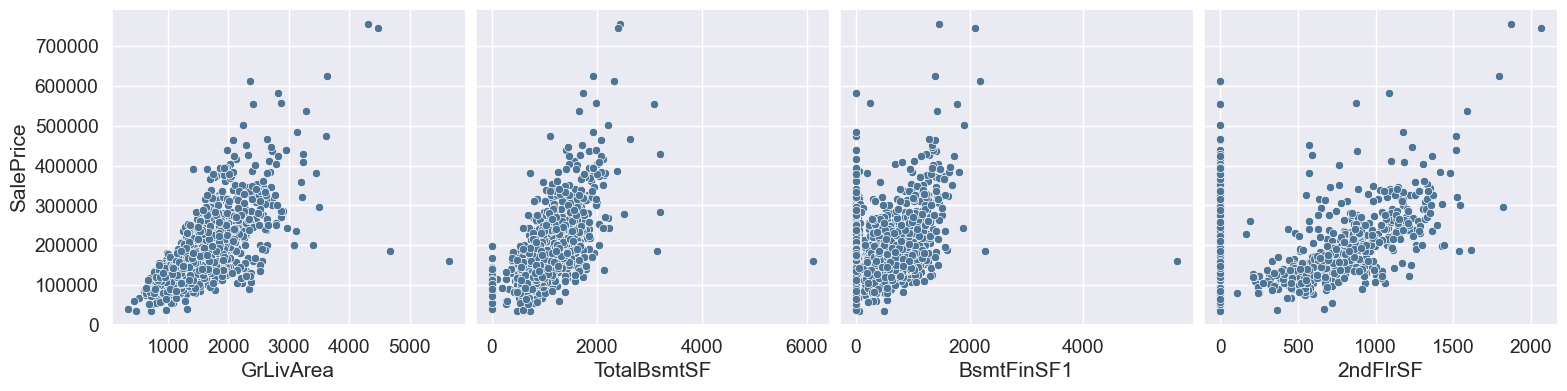

In [277]:
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta',
          'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue',
          'xkcd:scarlet']

features_pair_plot = ['GrLivArea', 'TotalBsmtSF', 'BsmtFinSF1', '2ndFlrSF']
sns.pairplot(initial_training_set, x_vars=features_pair_plot, y_vars="SalePrice", height=4, diag_kind='kde',
             plot_kws=dict(color=colors[8]),
             diag_kws=dict(fill=True, alpha=.7, color=colors[0]))

Sembrerebbe che le feature abbiano un andamento lineare.

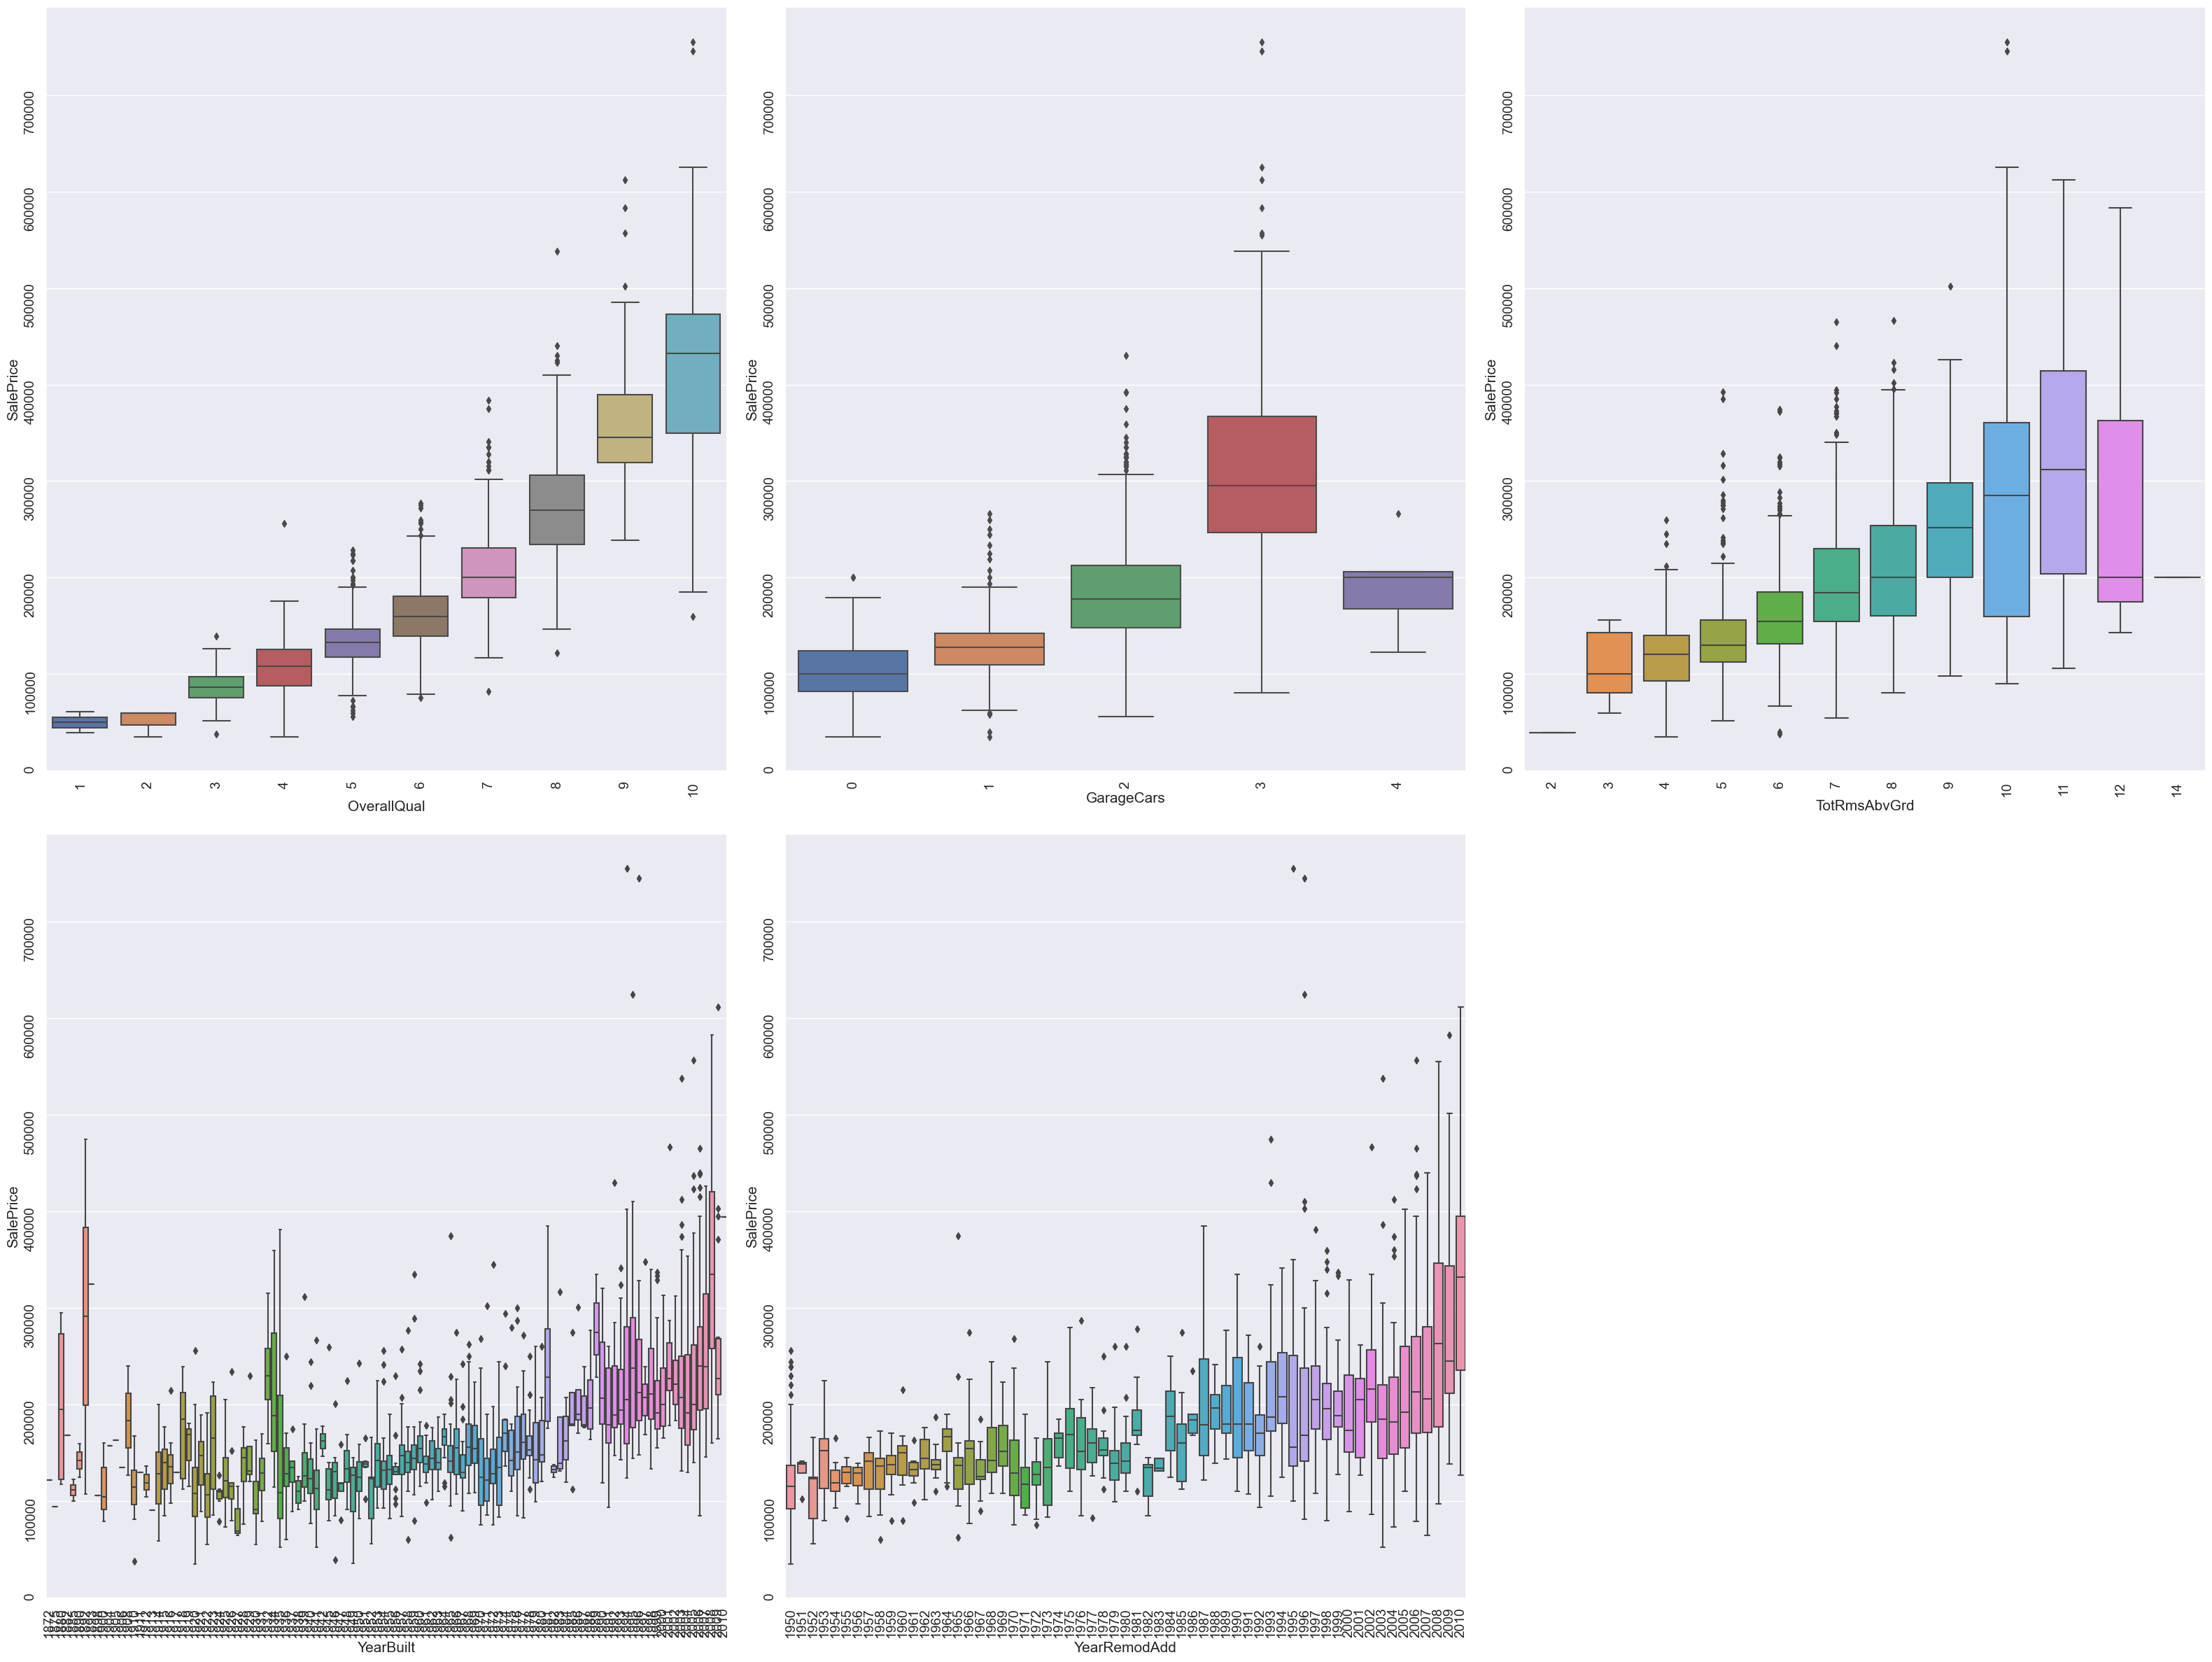

In [278]:
features_box_plot = ['OverallQual', 'GarageCars', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']

axis_x = 0
axis_y = 0
fig, axes = plt.subplots(2, 3, figsize=(32, 24))
for fbp in features_box_plot:
    f = sns.boxplot(ax=axes[axis_x, axis_y], data=initial_training_set, x=fbp, y='SalePrice')
    f.axis(ymin=0, ymax=800000)
    axes[axis_x, axis_y].tick_params(rotation=90)
    axes[axis_x, axis_y].autoscale(enable=True)
    fig.tight_layout()
    if axis_y == 2:
        axis_x = 1
        axis_y = 0
    else:
        axis_y += 1

fig.delaxes(axes[axis_x][2])

Possiamo notare che *'OverallQual'* influisce molto sul prezzo, infatti all'aumentare della qualità aumenta anche il prezzo delle case; mentre, sulle altre feature non influisce molto come la prima.

Studiamo se le feature hanno una distribuzione normale.

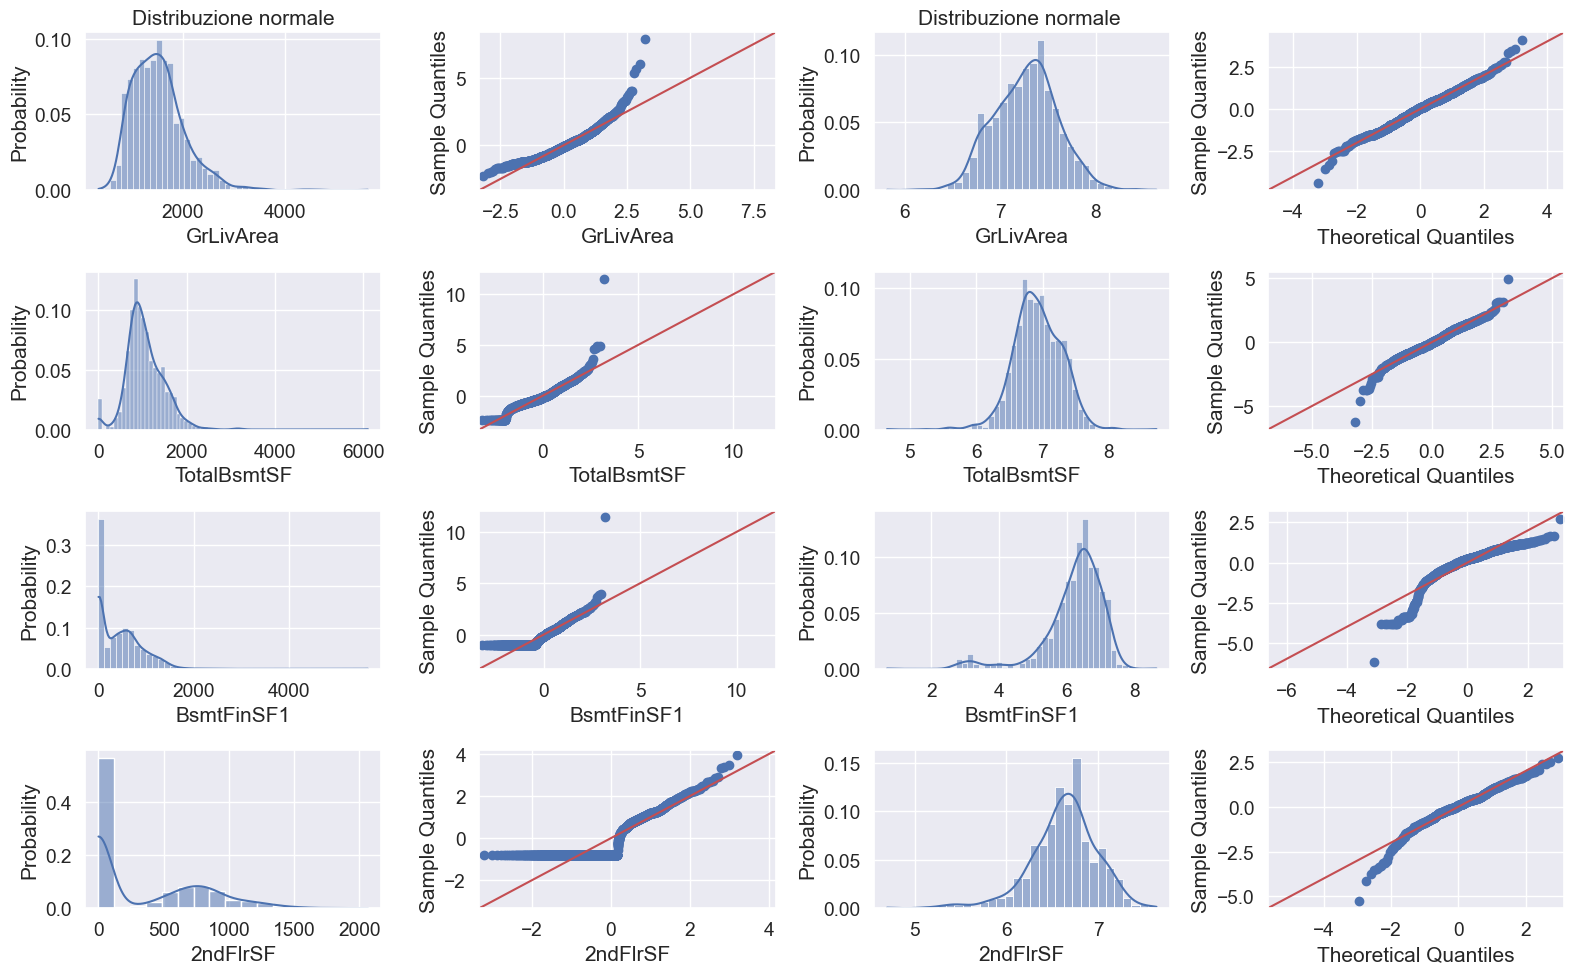

In [279]:
import statsmodels.api as sm


def distribution_plot(train_df: DataFrame, features: str):
    fig, axes = plt.subplots(features.__len__(), 4, figsize=(16, 10))
    axis = 0
    for feature in features:
        sns.histplot(ax=axes[axis, 0], data=train_df, x=feature, kde=True, stat="probability")
        sm.qqplot(ax=axes[axis, 1], data=train_df[feature], line='45', fit=True)
        # in questo caso si considerano valori > 0
        sns.histplot(ax=axes[axis, 2], data=np.log(train_df[train_df[feature] > 0][feature]),
                     kde=True, stat="probability")
        sm.qqplot(ax=axes[axis, 3], data=np.log(train_df[train_df[feature] > 0][feature]), line='45', fit=True)
        axes[0, 0].set_title("Distribuzione normale")
        axes[0, 2].set_title("Distribuzione normale ")
        axes[axis, 0].set_xlabel(feature)
        axes[axis, 1].set_xlabel(feature)
        plt.tight_layout()
        axis += 1


distribution_plot(initial_training_set, features_pair_plot)

E' possibile notare che in:
- **'GrLiveArea'**, ci sono più outliers, rispetto agli altri, e non si ha una distribuzione normale. Effettuando la trasformazione dei dati attraverso una *trasformazione log* si ottiene una distribuzione normale.

# 2. Data cleaning
Analizziamo il dataset per eliminare i valori nulli. In particolare adottiamo la seguente politica:
- se i valori nulli sono maggiori del 80% degli elementi del training set, eliminiamo la feature.
- altrimenti, se la feature è numerica, sostituiamo il valore nullo con il valore medio.
- altrimenti, se la feature è categorica, sostituiamo il valore nullo con il valore più comune.

Questo passaggio è necessario per il corretto funzionamento dei metodi di feature selection, feature extraction e per i modelli di machine learning che utilizzeremo.

## 2.1 Rimozione delle colonne con molti valori nulli
Innanzitutto realizziamo un grafico con le features che hanno almeno un valore nullo:

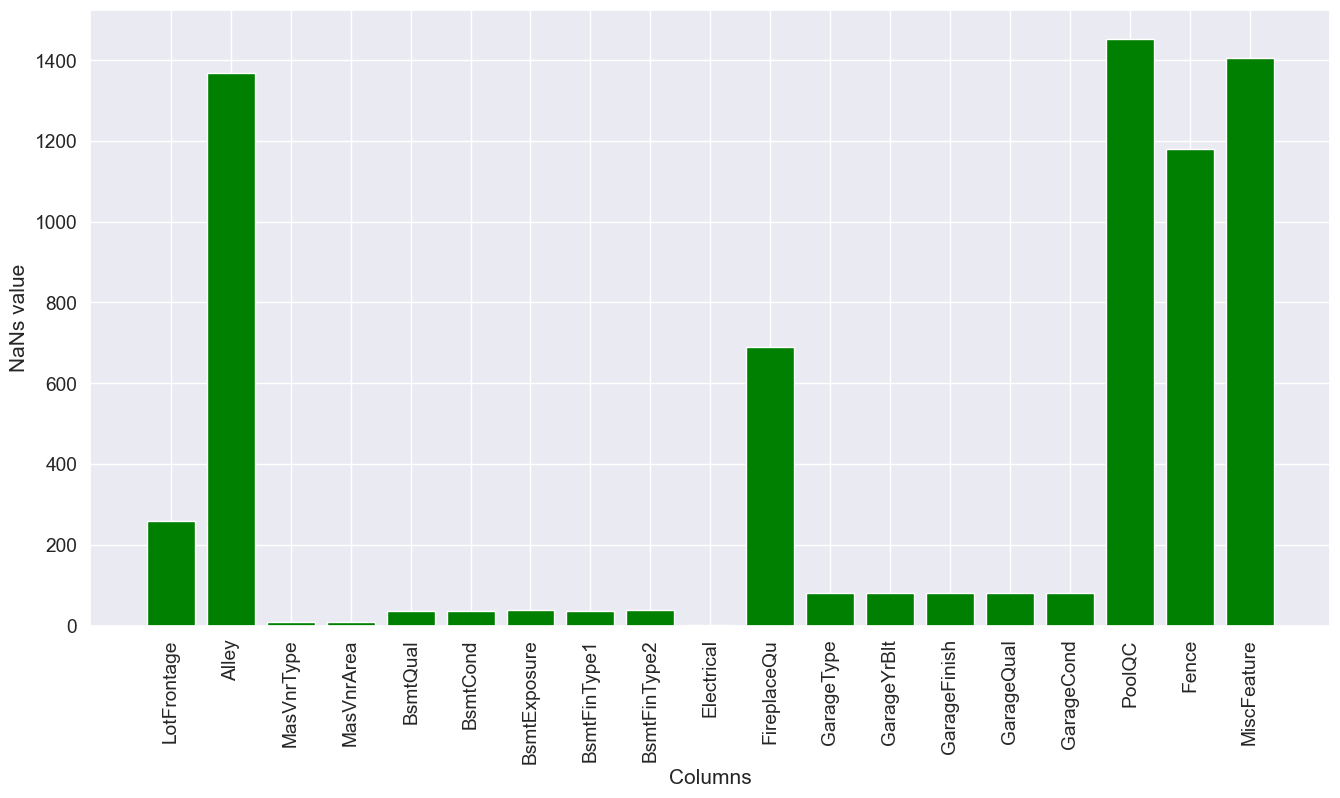

Colonne con valori nulli:  19


In [280]:
def get_nan_cols(dataset: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Index]:
    """ Restituisce:
        0: un dataframe con nome colonna, numero null
        1: una lista (Index) con i nomi delle colonne che hanno valori nulli
    """
    count_nan = dataset.isnull().sum(axis=0)
    columns_with_nan_df = count_nan.loc[count_nan != 0]
    nan_cols_names = dataset.columns[dataset.isna().any()]
    return columns_with_nan_df, nan_cols_names


def get_cols_with_nan_number(dataset: pd.DataFrame):
    print("Colonne con valori nulli: ", len(get_nan_cols(dataset)[1].to_list()))


def check_nan_value(dataset):
    # Verifichiamo se ci sono valori NaN
    columns_with_nan_df, nan_cols_names = get_nan_cols(dataset)
    pd.DataFrame(data=nan_cols_names)
    plt.figure(figsize=(16, 8))
    plt.bar(nan_cols_names, columns_with_nan_df, color="green")
    plt.xlabel("Columns")
    plt.xticks(rotation=90)
    plt.ylabel("NaNs value")
    plt.show()


check_nan_value(initial_training_set)
get_cols_with_nan_number(initial_training_set)

Notiamo che ci sono 19 colonne che hanno almeno un valore nullo. In particolare: **Alley**, **PoolQC**, **Fence** e **MiscFeature** hanno più dell'85% di valori nulli, quindi le **eliminiamo**

Numero di valori non nulli minimo:  293


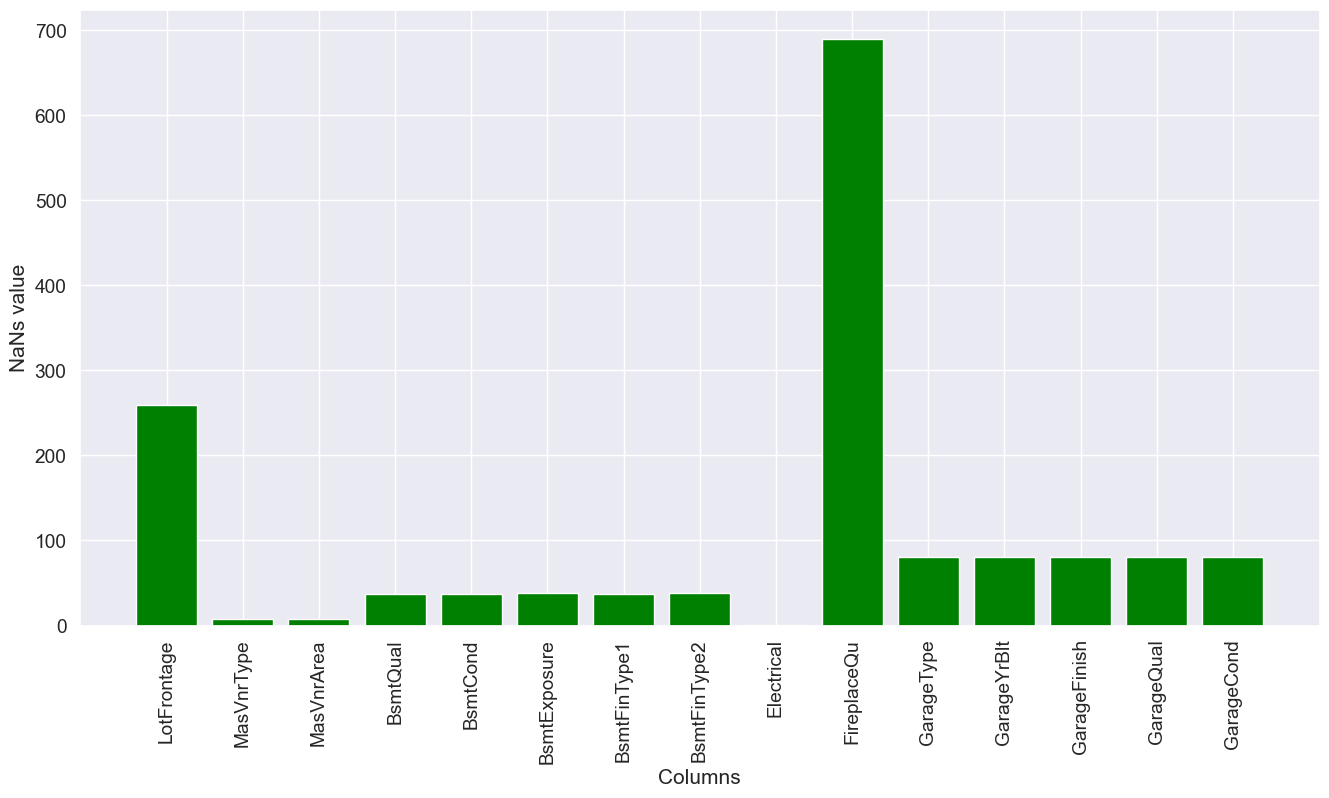

Colonne con valori nulli:  15


In [281]:
def remove_nan_columns(dataset: DataFrame, threshold=20) -> DataFrame:
    """Elimina colonne con valori NaN quando i valori Nan sono superiori a [threshold]%"""
    thresh = int((len(dataset) * threshold) / 100) + 1
    print("Numero di valori non nulli minimo: ", thresh)
    # axis: specifichiamo di eliminare solo le colonne; thresh: numero minimo per eliminare
    dataset.dropna(axis='columns', thresh=thresh, inplace=True)
    return dataset


initial_training_set2 = remove_nan_columns(initial_training_set)
check_nan_value(initial_training_set2)  # senza troppi valori nulli
get_cols_with_nan_number(initial_training_set2)

## 2.2 Sostituzione dei valori nulli nelle feature numeriche

Consideriamo le colonne numeriche dopo aver eliminato le colonne con valori NaN:


In [282]:
numerical_cols = initial_training_set2.select_dtypes(include='number').columns.to_list()
numerical_train = initial_training_set2[numerical_cols]
print(numerical_cols)

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


L'Id non ci serve, quindi lo togliamo:

In [283]:
if len(numerical_cols) > 0 and numerical_cols[0] == 'Id':
    del numerical_cols[0]
numerical_train = numerical_train.drop(['Id'], axis=1, errors='ignore')
initial_training_set2 = initial_training_set2.drop(['Id'], axis=1, errors='ignore')

Sostituiamo alle colonne numeriche del training set `initial_training_set2` a cui abbiamo eliminato le colonne con oltre l'80% dei valori nulli, la media dei valori al posto dei rimanenti valori NaN

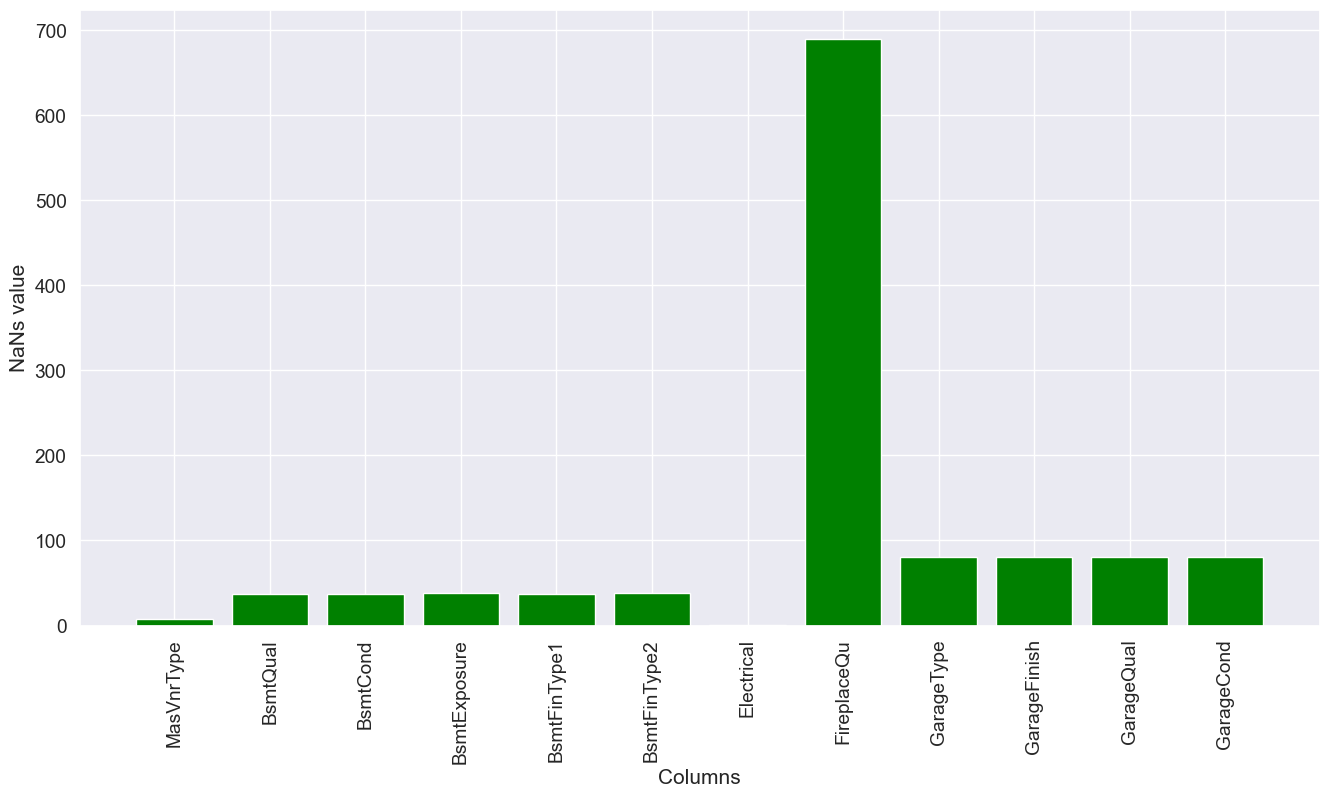

Colonne con valori nulli:  12
      MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0             60       RL         65.0     8450   Pave      Reg         Lvl   
1             20       RL         80.0     9600   Pave      Reg         Lvl   
2             60       RL         68.0    11250   Pave      IR1         Lvl   
3             70       RL         60.0     9550   Pave      IR1         Lvl   
4             60       RL         84.0    14260   Pave      IR1         Lvl   
...          ...      ...          ...      ...    ...      ...         ...   
1455          60       RL         62.0     7917   Pave      Reg         Lvl   
1456          20       RL         85.0    13175   Pave      Reg         Lvl   
1457          70       RL         66.0     9042   Pave      Reg         Lvl   
1458          20       RL         68.0     9717   Pave      Reg         Lvl   
1459          20       RL         75.0     9937   Pave      Reg         Lvl   

     Utilities LotCon

In [284]:
initial_training_set2 = initial_training_set2.fillna(initial_training_set2[numerical_cols].mean())
check_nan_value(initial_training_set2)  # senza troppi valori nulli
get_cols_with_nan_number(initial_training_set2)
print(initial_training_set2)

## 2.3 Sostituzione dei valori nulli nelle feature categoriche

Per prima cosa prendiamo le colonne categoriche

In [285]:
categorical_cols = initial_training_set2.select_dtypes(include='object').columns.to_list()
categorical_train = initial_training_set2[categorical_cols]
print(categorical_cols)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


Sostituiamo alle colonne **categoriche** del training set `initial_training_set2` a cui abbiamo eliminato le colonne con oltre l'80% dei valori nulli e i valori nulli delle colonne numeriche, la moda dei valori al posto dei rimanenti valori NaN.

In [286]:
mode = categorical_train.mode()
print(f"Valori più frequenti\n{mode.iloc[0]}\n\n")
initial_training_set2 = initial_training_set2.fillna(mode.iloc[0])
get_cols_with_nan_number(initial_training_set2)

Valori più frequenti
MSZoning              RL
Street              Pave
LotShape             Reg
LandContour          Lvl
Utilities         AllPub
LotConfig         Inside
LandSlope            Gtl
Neighborhood       NAmes
Condition1          Norm
Condition2          Norm
BldgType            1Fam
HouseStyle        1Story
RoofStyle          Gable
RoofMatl         CompShg
Exterior1st      VinylSd
Exterior2nd      VinylSd
MasVnrType          None
ExterQual             TA
ExterCond             TA
Foundation         PConc
BsmtQual              TA
BsmtCond              TA
BsmtExposure          No
BsmtFinType1         Unf
BsmtFinType2         Unf
Heating             GasA
HeatingQC             Ex
CentralAir             Y
Electrical         SBrkr
KitchenQual           TA
Functional           Typ
FireplaceQu           Gd
GarageType        Attchd
GarageFinish         Unf
GarageQual            TA
GarageCond            TA
PavedDrive             Y
SaleType              WD
SaleCondition     Normal
Name

# 2. Preprocessing
Trasformiamo tutte le colonne categoriche in numeriche.
- Se la colonna categorica rappresenta una valutazione, usiamo l'ordinal encoding
- Altrimenti usiamo one-hot encoding (one-of-k). In tal caso le feature aumenteranno quindi bisogna controllare il numero di colonne finale.

Per prima cosa determiniamo le colonne categoriche che vanno trasformate con l'**ordinal encoding** e quelle che vanno trasformate con l'one hot encoding, a partire dal file `valutazioneFeature.csv`.

In [287]:
ordinal_enc_cols = [
    "ExterQual",
    "KitchenQual",
    "ExterCond",
    "HeatingQC",
    "BsmtCond",
    "BsmtFinType1",
    "BsmtFinType2",
    "GarageCond",
    "BsmtExposure",
    "GarageQual",
    "FireplaceQu",
    "BsmtQual"
]

onehot_enc_cols = [
    "MSZoning",
    "Condition1",
    "Electrical",
    "Functional",
    "Utilities",
    "Condition2",
    "Exterior1st",
    "BldgType",
    "CentralAir",
    "Exterior2nd",
    "Heating",
    "HouseStyle",
    "RoofMatl",
    "Street",
    "LotConfig",
    "Neighborhood",
    "LandSlope",
    "Foundation",
    "LandContour",
    "MasVnrType",
    "PavedDrive",
    "RoofStyle",
    "SaleType",
    "GarageFinish",
    "GarageType",
    "LotShape",
    "SaleCondition"
]

## 3.1 Ordinal encoding

Eseguiamo prima l'ordinal encoding:

In [288]:
def ordinal_encoding(dataset: DataFrame, ord_enc_cols: List[str]) -> DataFrame:
    # applica l'ordinal Encoding alle colonne categoriche che rappresentano una valutazione
    copy = dataset.copy()
    for cat in ord_enc_cols:
        copy[cat], _ = pd.factorize(dataset[cat])

    return copy


initial_training_set3 = ordinal_encoding(initial_training_set2, ordinal_enc_cols)

print("Alcune delle colonne prima e dopo l'ordinal encoding")
print(initial_training_set2[ordinal_enc_cols[:3]])
print(initial_training_set3[ordinal_enc_cols[:3]])

Alcune delle colonne prima e dopo l'ordinal encoding
     ExterQual KitchenQual ExterCond
0           Gd          Gd        TA
1           TA          TA        TA
2           Gd          Gd        TA
3           TA          Gd        TA
4           Gd          Gd        TA
...        ...         ...       ...
1455        TA          TA        TA
1456        TA          TA        TA
1457        Ex          Gd        Gd
1458        TA          Gd        TA
1459        Gd          TA        TA

[1460 rows x 3 columns]
      ExterQual  KitchenQual  ExterCond
0             0            0          0
1             1            1          0
2             0            0          0
3             1            0          0
4             0            0          0
...         ...          ...        ...
1455          1            1          0
1456          1            1          0
1457          2            0          1
1458          1            0          0
1459          0            1          

## 3.2 One hot encoding

Ora eseguiamo il one hot encoding. Il numero iniziale di colonne è:

In [289]:
initial_training_set3.shape[1]

76

In [290]:
def one_hot_encoding(dataset: DataFrame, one_hot_cols: List[str]) -> DataFrame:
    """
    Mappa le features categoriche in nuove colonne in formato one-hot
    :param dataset: self.train o self.test
    :return: il DataFrame di train o test con le stringhe trasformate in ulteriori colonne one-hot (con i nomi)
    """

    copy = dataset.copy()

    # applica il One Hot Encoding alle colonne categoriche
    encoded_df = pd.get_dummies(dataset[one_hot_cols])

    # aggiunge il prefisso al nome delle colonne
    prefix_dict = {col: f"{col}_{val}" for col in one_hot_cols for val in dataset[col].unique()}

    encoded_df.add_prefix('').rename(columns=prefix_dict)

    only_non_one_hot = copy.drop(columns=one_hot_cols, axis=1)
    result_df = pd.concat([only_non_one_hot, encoded_df], axis=1)

    return result_df


initial_training_set4 = one_hot_encoding(initial_training_set3, one_hot_cols=onehot_enc_cols)
initial_training_set4.to_csv("../dataset/train_encoded.csv", index=False)
print(initial_training_set4.shape[1])

231


Notiamo che il numero di colonne è passato da 76 a 231. Quindi in seguito sarà necessario determinare quali colonne sono più informative rispetto alla variabile target SalePrice.

Prima di andare avanti, eliminiamo queste feature molto correlate tra loro:

In [291]:
initial_training_set5 = initial_training_set4.drop(columns=worst_features_list, axis=1)
print(len(initial_training_set4.columns))
print(len(initial_training_set5.columns))

231
221


Abbiamo quindi ridotto il numero di colonne da 231 a 221 (compreso il target).

# 3. Suddivisione training - testing set

In [292]:
initial_training_shuffle = initial_training_set5.sample(frac=1, random_state=42).reset_index(drop=True)

In [293]:
initial_X = initial_training_shuffle.iloc[:,
            initial_training_shuffle.columns != 'SalePrice']  # tutte le colonne tranne l'ultima
initial_y = pd.Series(initial_training_shuffle["SalePrice"], name="SalePrice")  # solo l'ultima colonna
X_train, X_test, y_train, y_test = train_test_split(initial_X, initial_y, test_size=0.2, random_state=42)

print(f"shape train X: {X_train.shape}")
print(f"shape train y: {y_train.shape}")
print(f"shape test X: {X_test.shape}")
print(f"shape test y: {y_test.shape}")

print(X_train)

shape train X: (1168, 220)
shape train y: (1168,)
shape test X: (292, 220)
shape test y: (292,)
      MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
254           20    70.049958    11553            5            5       1968   
1066          20    60.000000     8072            5            5       1994   
638           70   144.000000    21384            5            6       1923   
799           50    70.049958    13650            5            5       1958   
380           20    71.000000     9187            6            5       1983   
...          ...          ...      ...          ...          ...        ...   
1095          20    70.000000    10150            5            5       1958   
1130          60    70.000000     8462            6            5       1994   
1294          80    80.000000     9600            6            6       1955   
860           60    70.049958    28698            5            5       1967   
1126          60    63.000000     7

Usiamo il metodo seguente per suddividere il training set iniziale in diversi train/test set sulla base della cross validation

In [294]:
class Fold:
    def __init__(self, fold_id: int, X_train: DataFrame, y_train: Series, X_test: DataFrame, y_test: DataFrame,
                 scaler=StandardScaler()):
        self.fold_id = fold_id
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.X_train_normalized = None
        self.X_test_normalized = None
        self.X_train_normalized_fs = None
        self.X_test_normalized_fs = None
        self.scale_features(scaler)

    def check_ok(self, initial_size):
        return self.X_train.shape[0] + self.X_test.shape[0] == initial_size

    def print_shapes(self):
        print(f"{self.fold_id} shape x train: {self.X_train.shape} " +
              f"{self.fold_id} shape y train: {self.y_train.shape} " +
              f"{self.fold_id} shape x test : {self.X_test.shape} " +
              f"{self.fold_id} shape y test : {self.y_test.shape}")

    def scale_features(self, scaler=StandardScaler()):
        self.X_train_normalized = scale_features(self.X_train, scaler)
        self.X_test_normalized = scale_features(self.X_test, scaler)


def split_dataset(initial_dataset_x, initial_y, splits=10) -> List[Fold]:
    lista: List[Fold] = []
    n_elements = len(initial_dataset_x)
    for split in range(splits):
        # dataset: |-1-|-2-|...|-10-|
        if split == 0:  # training: |-2-10| testing: |-1-|
            f = Fold(fold_id=split,
                     X_train=initial_dataset_x.iloc[(n_elements // splits):, :],
                     y_train=initial_y[(n_elements // splits):],
                     X_test=initial_dataset_x.iloc[:(n_elements // splits), :],
                     y_test=initial_y[:(n_elements // splits)])
            lista.append(f)
        elif split == n_elements - 1:  # training: |-1-9| testing: |-10-|
            f = Fold(fold_id=split,
                     X_train=initial_dataset_x.iloc[:split *
                                                     (n_elements // splits), :],
                     y_train=initial_y[:split * (n_elements // splits)],
                     X_test=initial_dataset_x.iloc[split *
                                                   (n_elements // splits):, :],
                     y_test=initial_y[split * (n_elements // splits):])
            lista.append(f)
        else:  # training: |-1-i||(i+1)-10| testing: |-i-(i+1)-|
            before_test_x = initial_dataset_x.iloc[:split * (n_elements // splits), :]
            after_test_x = initial_dataset_x.iloc[(split + 1) * (n_elements // splits):, :]

            x_train_appended: DataFrame = pd.concat([before_test_x, after_test_x])
            before_test_y = initial_y[:split * (n_elements // splits)]
            after_test_y = initial_y[(split + 1) * (n_elements // splits):]
            y_train_appended = pd.concat([before_test_y, after_test_y])

            lista.append(Fold(fold_id=split,
                              X_train=x_train_appended,
                              y_train=y_train_appended,
                              X_test=initial_dataset_x.iloc[split * (n_elements // splits):(
                                                                                                   split + 1) * (
                                                                                                   n_elements // splits),
                                     :],
                              y_test=initial_y[split * (n_elements // splits):(split + 1) * (n_elements // splits)]
                              )
                         )
    return lista


# 4. Normalizzazione dei dati
Normalizziamo i dati per migliorare l'accuratezza del modello


In [295]:
def scale_features(X_df, y_train=None, scaler=StandardScaler()):
    res = None
    if y_train is not None:
        res = scaler.fit_transform(X_df, y_train)
    else:
        res = scaler.transform(X_df)

    return pd.DataFrame(res, columns=X_df.columns)


# IMPORTANTE queta variabile folds deve essere usata nel seguito al posto di X_train / y_train / X_test / y_test
folds = split_dataset(initial_X, initial_y, splits=10)
for i, fold in enumerate(folds):
    # scaliamo il training set i
    robustScaler = RobustScaler()  # va ogni volta reinstanziato perché vogliamo resettarlo per ogni coppia train-test
    fold.X_train_normalized = scale_features(fold.X_train, y_train=fold.y_train, scaler=robustScaler)
    fold.X_test_normalized = scale_features(fold.X_test, scaler=robustScaler)
    print(fold.X_train)

      MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
146           50         86.0    11500            7            7       1936   
147           20         67.0    16285            7            5       2001   
148           85         60.0     7200            5            8       1972   
149           30         45.0     8248            3            3       1914   
150           30         80.0    11600            4            5       1922   
...          ...          ...      ...          ...          ...        ...   
1455          20         78.0     9317            6            5       2006   
1456          50         65.0     7804            4            3       1928   
1457          20         60.0     8172            5            7       1955   
1458          50         55.0     7642            7            8       1918   
1459         120         53.0     3684            7            5       2007   

      YearRemodAdd  MasVnrArea  ExterQual  ExterCon

Test di funzionamento:

In [296]:
folds = split_dataset(initial_X, initial_y)
for i, f in enumerate(folds):
    f.print_shapes()
    print(f.X_train)
    if not f.check_ok(len(initial_X)):
        raise "ERROR la somma delle lunghezze di train X / y e test X / y non coincide con la lunghezza iniziale"


0 shape x train: (1314, 220) 0 shape y train: (1314,) 0 shape x test : (146, 220) 0 shape y test : (146,)
      MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
146           50         86.0    11500            7            7       1936   
147           20         67.0    16285            7            5       2001   
148           85         60.0     7200            5            8       1972   
149           30         45.0     8248            3            3       1914   
150           30         80.0    11600            4            5       1922   
...          ...          ...      ...          ...          ...        ...   
1455          20         78.0     9317            6            5       2006   
1456          50         65.0     7804            4            3       1928   
1457          20         60.0     8172            5            7       1955   
1458          50         55.0     7642            7            8       1918   
1459         120         

# 5. Feature Selection

Per eseguire la feature selection, sfruttiamo la mutua informazione. Se la mutua informazione di una feature $x_i$ è alta, allora tanto più la feature e il target $t$ sono dipendenti. Noi cerchiamo le feature che hanno la mutua informazione più alta possibile.

In [297]:
def mutual_info_feature_selection(x_train: DataFrame, y_train: Series, k: int) -> DataFrame:
    selector = SelectKBest(mutual_info_regression, k=k)
    x_new = selector.fit_transform(x_train, y_train)
    return pd.DataFrame(x_new, columns=selector.get_feature_names_out())


# Esempio di FS Senza normalizzazione
fs_X_train = mutual_info_feature_selection(folds[0].X_train, folds[0].y_train, 4)
print("old shape = ", folds[0].X_train.shape)
print("new shape = ", fs_X_train.shape)
fs_X_train

old shape =  (1314, 220)
new shape =  (1314, 4)


,OverallQual,YearBuilt,TotalBsmtSF,GrLivArea
0,7.0,1936.0,1017.0,2057.0
1,7.0,2001.0,1413.0,1430.0
2,5.0,1972.0,768.0,768.0
3,3.0,1914.0,864.0,864.0
4,4.0,1922.0,700.0,1180.0
...,...,...,...,...
1309,6.0,2006.0,1314.0,1314.0
1310,4.0,1928.0,1122.0,1981.0
1311,5.0,1955.0,864.0,864.0
1312,7.0,1918.0,912.0,1426.0


In [298]:
# Esempio di FS Con normalizzazione (vengono selezionate le stesse features)
fs_X_train_normalized = mutual_info_feature_selection(folds[0].X_train_normalized, folds[0].y_train, 4)
print("old shape = ", folds[0].X_train_normalized.shape)
print("new shape = ", fs_X_train_normalized.shape)
fs_X_train_normalized

old shape =  (1314, 220)
new shape =  (1314, 4)


,OverallQual,YearBuilt,TotalBsmtSF,GrLivArea
0,0.650071,-1.149679,-0.091069,1.035525
1,0.650071,0.984929,0.818618,-0.173416
2,-0.806355,0.032565,-0.663070,-1.449842
3,-2.262781,-1.872162,-0.442540,-1.264741
4,-1.534568,-1.609441,-0.819279,-0.655450
...,...,...,...,...
1309,-0.078142,1.149129,0.591196,-0.397080
1310,-1.534568,-1.412400,0.150136,0.888986
1311,-0.806355,-0.525717,-0.442540,-1.264741
1312,0.650071,-1.740801,-0.332274,-0.181129


Il metodo seguente esegue la feature selection per ogni fold, se non è stata già fatta

In [299]:
def do_fs_for_each_fold(folds: List[Fold], k_features, scaled=True):
    # eseguiamo la feature selection su tutti i fold e manteniamola in memoria, per ridurre il tempo di esecuzione totale
    for f in folds:
        x_train = f.X_train_normalized if scaled else f.X_train

        if f.X_train_normalized_fs is None:
            f.X_train_normalized_fs = mutual_info_feature_selection(x_train, f.y_train, k_features)
        if f.X_test_normalized_fs is None:
            f.X_test_normalized_fs = f.X_test_normalized[f.X_train_normalized_fs.columns]
    print("Feature selection... Done")
    return folds

# 5.1. PCA feature "extraction"
In alcuni modelli useremo la feature extraction PCA per ridurre la dimensionalità del dataset.

Output:
```
array([[-51.49623277, -46.22734751, -15.85185751, -19.14660844],
       [-51.49653515, -46.23255056, -15.8603108 , -19.14954904],
       [-51.07788852, -42.14849845, 138.81867608,  25.11343878],
       ...,
       [-51.49622469, -46.22918467, -15.84214061, -19.14408362],
       [-51.4965279 , -46.23061618, -15.84496731, -19.13382271],
       [-51.49737513, -46.23657475, -15.87169622, -19.15737974]])
```



In [300]:
from sklearn.decomposition import PCA


def pca_reduction(x_train, y_train, n_components=40) -> Tuple[DataFrame, PCA]:
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(x_train, y_train)
    return pd.DataFrame(X_train_pca), pca


# esempio di utilizzo
X_train_pca, fitted_pca = pca_reduction(folds[0].X_train_normalized, folds[0].y_train, n_components=40)
X_test_pca = fitted_pca.transform(folds[0].X_test_normalized)
X_train_pca.shape

(1314, 40)

# 6. Valutazione modelli

Definiamo una classe che mantiene i parametri di un modello

In [301]:
class BestParameters:
    def __init__(self, model: str, k_feature: int, alpha: float, other: Dict[str, float], r2: float, scores: List):
        self.model = model
        self.k_feature = k_feature
        self.alpha = alpha
        self.other = other
        self.r2 = r2
        self.scores = list(zip(*filter(lambda s: s[1] > 0, scores)))

    def print_parameters(self):
        print(f"Model: {self.model} " +
              f"k feature: {self.k_feature} " +
              f"alpha: {self.alpha} " +
              f"other: {self.other} " +
              f"r2: {self.r2} ")


parameters: List[BestParameters] = []

Esempio di uso di cross_val_predict()

In [302]:
from sklearn.metrics import r2_score
from sklearn.calibration import cross_val_predict

# metodo con cross val predict (è veloce, ma i risultati cambiano sempre...)
linear = LinearRegression()
fs_initial_X = mutual_info_feature_selection(initial_X, initial_y, 104)
y_pred = cross_val_predict(linear, fs_initial_X, initial_y, cv=5)

print(y_pred.shape)
print(r2_score(y_pred, initial_y))

(1460,)
0.7639567322251297


In [303]:
# metodo con la nostra classe Fold (15s, ma esce sempre lo stesso risultato!!!)
def our_cross_validation_test(folds: List[Fold], model: LinearRegression, scaled=True) -> float:
    sum_r2 = 0.0

    for f in folds:
        X_train = f.X_train if not scaled else f.X_train_normalized
        X_test = f.X_test if not scaled else f.X_test_normalized
        model.fit(X_train, f.y_train)
        y_pred = model.predict(X_test)
        sum_r2 += r2_score(y_true=f.y_test, y_pred=y_pred)
    return sum_r2 / len(folds)


def our_cross_validation_test_with_fs(folds: List[Fold], model: LinearRegression, select_k, scaled=True) -> float:
    sum_r2 = 0.0

    for f in folds:
        X_train = f.X_train if not scaled else f.X_train_normalized
        X_test = f.X_test if not scaled else f.X_test_normalized
        fs_train_X = mutual_info_feature_selection(X_train, f.y_train, select_k)
        model.fit(fs_train_X, f.y_train)
        fs_test_X = X_test[fs_train_X.columns]
        y_pred = model.predict(fs_test_X)
        sum_r2 += r2_score(y_true=f.y_test, y_pred=y_pred)
    return sum_r2 / len(folds)


mean_r2 = our_cross_validation_test(folds, LinearRegression())
print(mean_r2)  # bad

mean_r2 = our_cross_validation_test(folds, LinearRegression(), scaled=False)
print(mean_r2)  # 0.8097

mean_r2 = our_cross_validation_test_with_fs(folds, LinearRegression(), 129)
print(mean_r2)  # 0.8239

mean_r2 = our_cross_validation_test_with_fs(folds, LinearRegression(), 129, scaled=False)
print(mean_r2)  # 0.826

-9.51626747103846e+24
0.7910860522577388
-2.627559774934157e+21
0.8012690537571097


## 6.1 Regressione Lineare
Eseguiamo la model selection sulla regressione lineare e calcoliamone le performance tramite cross-validation.

In [304]:
def linear_regression_cv(x_train: DataFrame, y_train: Series, scaled=False) -> Tuple[float, Any]:
    model = LinearRegression()
    val_folds = split_dataset(x_train, y_train, splits=10)
    r2 = our_cross_validation_test(val_folds, model, scaled=scaled)  # non selezioniamo
    #r2 = cross_val_score(model, x_train, y_train, cv=10, scoring='r2').mean()
    return r2, model


# Esempio con e senza FS / Normalizzazione
print("r2 initial without feature selection", linear_regression_cv(folds[0].X_train, folds[0].y_train)[0])
print("r2 initial with feature selection", linear_regression_cv(fs_X_train, folds[0].y_train)[0])
print("r2 normalized without feature selection",
      linear_regression_cv(folds[0].X_train, folds[0].y_train, scaled=True)[0])
print("r2 normalized with feature selection", linear_regression_cv(fs_X_train, folds[0].y_train, scaled=True)[0])

r2 initial without feature selection 0.7632611944846582
r2 initial with feature selection 0.7252885313272063
r2 normalized without feature selection -1.3359652603772653e+25
r2 normalized with feature selection 0.740978805676218


Notiamo che con la feature selection i risultati sono molto migliori, in quanto il coefficiente $R^2$ si avvicina molto di più a 1. Ora cerchiamo il miglior valore di k per la feature selection con la regressione lineare

In [305]:
def best_feature_selection_k(folds: List[Fold], with_fs=True, scaled=True):
    max_features = int(X_train.shape[1] / 2)
    best_k = 0
    scores = []  # mettiamo tutto in questa funzione!!!
    best_r2 = 0.0

    #for k in range(1, max_features):
    for k in [4, 104, 129]:
        fs_X_train = mutual_info_feature_selection(folds[0].X_train, folds[0].y_train, k) if with_fs else X_train

        r2_score_cv_sum = 0.0
        r2_score_sum = 0.0
        for f in folds:
            r2_score_cv, model = linear_regression_cv(f.X_train[fs_X_train.columns], f.y_train,
                                                      scaled=scaled)  # se metti False, il test migl
            r2_score_cv_sum += r2_score_cv
            r2_score_sum += model.score(f.X_test_normalized[fs_X_train.columns], f.y_test) if scaled else model.score(
                f.X_test[fs_X_train.columns], f.y_test)
        r2_score_cv = r2_score_cv_sum / len(folds)
        r2_score = r2_score_sum / len(folds)

        print(f"iteration {k} of {max_features}: r2 = {r2_score:.6f}")
        print(f"Linear regression - k = {k} - r2_cv = {r2_score_cv:.6f} - r2_test = {r2_score:.6f} ")
        scores.append((k, r2_score, r2_score_cv))
        if r2_score > best_r2:
            best_r2 = r2_score_cv
            best_k = k
    return best_k, scores


k, scores_linear_regression = best_feature_selection_k(folds, scaled=False)
print(f"Best k is {k}")

iteration 4 of 110: r2 = 0.740293
Linear regression - k = 4 - r2_cv = 0.739046 - r2_test = 0.740293 
iteration 104 of 110: r2 = 0.810167
Linear regression - k = 104 - r2_cv = 0.807535 - r2_test = 0.810167 
iteration 129 of 110: r2 = 0.802969
Linear regression - k = 129 - r2_cv = 0.797262 - r2_test = 0.802969 
Best k is 104


Andamento di $R^2$ al variare del numero di feature selezionate $k$ (escludiamo i valori negativi molto grandi in valore assoluto).

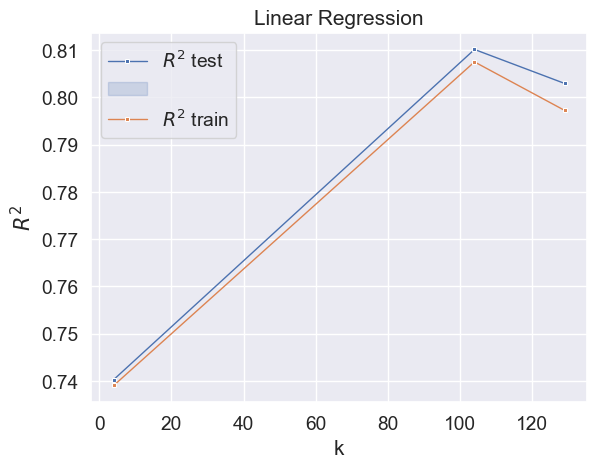

In [337]:
def plot_scores(data, label_x, label_y, idx_x=0, idx_y=1):
    # inizialmente data è [(k1,...,kn), (r21, ...,r2n)]
    data = zip(list(data[idx_x]), list(data[idx_y]))
    # ora data è [(k1,r21),...,(kn,r2n)]
    data = pd.DataFrame(data, columns=[label_x, label_y])
    # ora è un dataframe, quindi possiamo visualizzare i nomi degli assi
    sns.lineplot(data=data, x=label_x, y=label_y, marker='s', markersize=3.5, linewidth=1).set_title(p.model)


p = BestParameters("Linear Regression", k, 0.0, {}, 0.0, scores_linear_regression)
parameters.append(p)
plot_scores(p.scores, "k", "$R^2$", idx_x=0, idx_y=1)  # LaTeX funziona anche in SnS
plot_scores(p.scores, "k", "$R^2$", idx_x=0, idx_y=2)  # LaTeX funziona anche in SnS
plt.legend(labels=["$R^2$ test", "", "$R^2$ train"])

Il grafico mostra che all'aumentare del numero di feature la performance migliora fino ad un valore pari a 129, che risulta essere il migliore.

## 6.2 Regressione polinomiale
Corrisponde a usare $m$ funzioni base polinomiale $\phi_j(\bold{x})=x^j$ per trasformare il dataset. Il grado massimo del polinomio è $m-1$. Vogliamo quindi trovare il miglior grado del polinomio che massimizza r2.

In [307]:
from scipy.special import binom

deg = 2
new_features = binom(220, deg)
print(f"Con 220 features, il polinomio di regressione di grado {deg} avrà {new_features} termini al più")

deg = 2
new_features = binom(40, deg)
print(f"Con 40 features, il polinomio di regressione di grado {deg} avrà {new_features} termini al più")

Con 220 features, il polinomio di regressione di grado 2 avrà 24090.0 termini al più
Con 40 features, il polinomio di regressione di grado 2 avrà 780.0 termini al più


Però poichè le feature iniziali sono 220, anche un polinomio di grado 2 produrrebbe ben 24090 features con PolynomialFeature, che sono decisamente troppe. Per ridurre la dimensionalità, quindi usiamo PCA per ridurre il numero di feature ad esempio a 40.

In [308]:
def polynomial_transformation(x_train: DataFrame, d=2, only_interactions=False) -> DataFrame:
    """
    d: grado del polinomio di regressione
    only_interactions: non mette le potenze ma solo le coppie (o tuple di dimensione massima d) di features
    Trasforma il dataset di partenza da un dataset con n feature a un dataset m >> n feature.
    Ad esempio con 4 feature un polinomio di grado 2 produrrebbe 15 features:
    1, x1, x2, x3, x4, x1x2, x1x3, x1x4, x2x3, x2x4, x3x4, x1^2, x2^2, x3^2, x4^2
    """
    # include_bias=False significa che non si forza l'intercetta y=0
    poly = PolynomialFeatures(degree=d, include_bias=False, interaction_only=only_interactions)
    # usiamo le funzioni base per trasformare il dataset (in questo caso aumenta d*(d-1)/2 il numero di features)
    x_train_poly = poly.fit_transform(x_train)
    print("old shape", x_train.shape)
    print("new shape", x_train_poly.shape)
    return pd.DataFrame(x_train_poly)


desired_feature_number = 40  # numero di feature a cui portare il dataset con PCA
poly_degree = 2  # grado del polinomio (non aumentarlo troppo!)

X_train_pca = pca_reduction(folds[0].X_train_normalized, folds[0].y_train, desired_feature_number)[0]
print("Feature ridotte da 220 con PCA: ", X_train_pca.shape)
X_train_fs_104 = mutual_info_feature_selection(folds[0].X_train_normalized, folds[0].y_train, 104)
print("Feature selezionate: ", X_train_fs_104.shape)
X_train_fs_pca = pca_reduction(X_train_fs_104, folds[0].y_train, desired_feature_number)[0]
print("Feature ridotte da 104 con MI e PCA: ", X_train_fs_pca.shape)

# Esempio con e senza FS / Normalizzazione (senza polinomiale regression)
print("r2 linear normalized with PCA", linear_regression_cv(X_train_pca, folds[0].y_train))
print("r2 linear normalized with PCA and feature selection", linear_regression_cv(X_train_fs_pca, folds[0].y_train))

# Con polynomial regression grado 2
poly_train_pca = polynomial_transformation(X_train_pca, d=poly_degree)
poly_train_pca_fs = polynomial_transformation(X_train_fs_pca, d=poly_degree)
print(f"r2 poly (deg {poly_degree}) normalized with PCA", linear_regression_cv(poly_train_pca, folds[0].y_train))
print(f"r2 poly (deg {poly_degree}) normalized with PCA and feature selection",
      linear_regression_cv(poly_train_pca_fs, folds[0].y_train))

# Con polynomial regression grado 2 solo interazioni
poly_train_pca = polynomial_transformation(X_train_pca, d=poly_degree, only_interactions=True)
poly_train_pca_fs = polynomial_transformation(X_train_fs_pca, d=poly_degree, only_interactions=True)
print(f"r2 poly (deg {poly_degree}) normalized with PCA (interactions only)",
      linear_regression_cv(poly_train_pca, folds[0].y_train))
print(f"r2 poly (deg {poly_degree}) normalized with PCA and feature selection (interactions only)",
      linear_regression_cv(poly_train_pca_fs, folds[0].y_train))

# Con polynomial regression grado 1 solo interazioni (coincide con la regressione lineare)
poly_train_pca = polynomial_transformation(X_train_pca, d=1, only_interactions=True)
poly_train_pca_fs = polynomial_transformation(X_train_fs_pca, d=1, only_interactions=True)
print("r2 poly (deg1) normalized with PCA (interactions only)", linear_regression_cv(poly_train_pca, folds[0].y_train))
print("r2 poly (deg1) normalized with PCA and feature selection (interactions only)",
      linear_regression_cv(poly_train_pca_fs, folds[0].y_train))



Feature ridotte da 220 con PCA:  (1314, 40)
Feature selezionate:  (1314, 104)
Feature ridotte da 104 con MI e PCA:  (1314, 40)
r2 linear normalized with PCA (0.6613150679206716, LinearRegression())
r2 linear normalized with PCA and feature selection (0.7591521769771449, LinearRegression())
old shape (1314, 40)
new shape (1314, 860)
old shape (1314, 40)
new shape (1314, 860)
r2 poly (deg 2) normalized with PCA (-92.85152083931753, LinearRegression())
r2 poly (deg 2) normalized with PCA and feature selection (-6.773896926004795, LinearRegression())
old shape (1314, 40)
new shape (1314, 820)
old shape (1314, 40)
new shape (1314, 820)
r2 poly (deg 2) normalized with PCA (interactions only) (-21.81002179615708, LinearRegression())
r2 poly (deg 2) normalized with PCA and feature selection (interactions only) (-1.1014068098401373, LinearRegression())
old shape (1314, 40)
new shape (1314, 40)
old shape (1314, 40)
new shape (1314, 40)
r2 poly (deg1) normalized with PCA (interactions only) (0.66

Anche guardando solo questi valori di r2, si nota che i migliori risultati si hanno con la regressione lineare.

## 6.3 Lasso Regression
Eseguiamo la regressione lasso e calcoliamo le performance tramite cross-validation e confrontiamo utilizzando il training set dopo la feature selection e senza.

In [309]:
def lasso_regression_cv(x_train: DataFrame, y_train: Series, alpha=1.0, scaled=False) -> Tuple[float, Any]:
    model = Lasso(alpha=alpha, max_iter=10000, tol=0.1, random_state=42)
    val_folds = split_dataset(x_train, y_train, splits=10)
    r2 = our_cross_validation_test(val_folds, model,
                                   scaled=scaled)  # non selezioniamo, lo facciamo prima di chiamare questa funzione
    # r2 = cross_val_score(model, x_train, y_train, cv=10, scoring='r2').mean()
    return r2, model


# Esempio con e senza FS / Normalizzazione
print("r2 initial without feature selection", lasso_regression_cv(folds[0].X_train, folds[0].y_train)[0])
print("r2 initial with feature selection", lasso_regression_cv(fs_X_train, folds[0].y_train)[0])
print("r2 normalized without feature selection", lasso_regression_cv(folds[0].X_train_normalized, folds[0].y_train)[0])
print("r2 normalized with feature selection", lasso_regression_cv(fs_X_train_normalized, folds[0].y_train)[0])

r2 initial without feature selection 0.698297068125892
r2 initial with feature selection 0.7252883184995761
r2 normalized without feature selection 0.7405470404459222
r2 normalized with feature selection 0.7253201655612289


Notiamo che con la feature selection i risultati sono leggermente migliori, in quanto il coefficiente $R^2$ si avvicina molto di  Determiniamo il miglior valore di *alpha* per la regressione Lasso:più a 1.

In [310]:
def best_alpha_lasso(folds: List[Fold], k_features=104, scaled=True):
    scores = []
    best_alpha = 0
    best_r2 = 0.0
    #alphas = list(np.linspace(0.1, 20, 20))
    alphas = [1, 5, 50, 100, 300, 500, 1000, 1040, 1100, 1200, 1500, 2000]

    # eseguiamo la feature selection su tutti i fold e manteniamola in memoria, per ridurre il tempo di esecuzione totale
    folds = do_fs_for_each_fold(folds, k_features)

    # poi eseguiamo la model selection per trovare il migliore alpha
    for a in alphas:
        r2_score_cv_sum = 0.0
        r2_score_sum = 0.0
        for f in folds:
            r2_score_cv, model = lasso_regression_cv(f.X_train_normalized_fs, f.y_train, a,
                                                     scaled=scaled)  # se metti False, il test migl
            r2_score_cv_sum += r2_score_cv
            r2_score_sum += model.score(f.X_test_normalized_fs, f.y_test)
        r2_score_cv = r2_score_cv_sum / len(folds)
        r2_score = r2_score_sum / len(folds)
        print(f"Lasso alpha = {a:.4f} - k = {k} - r2_cv = {r2_score_cv:.6f} - r2_test = {r2_score:.6f} ")
        scores.append((a, r2_score, r2_score_cv))
        if r2_score > best_r2:
            best_r2 = r2_score
            best_alpha = a
    return best_alpha, scores


# alphas = [0.1, 0.2, 0.5, 1, 2, 5, 10]
alpha_lasso, scores_lasso = best_alpha_lasso(folds, k)
#print("Lasso without normalization")
#alpha_lasso_no_scaled, scores_lasso_no_scaled = best_alpha_lasso(folds, k, scaled=False)

Feature selection... Done
Lasso alpha = 1.0000 - k = 104 - r2_cv = 0.801971 - r2_test = 0.802008 
Lasso alpha = 5.0000 - k = 104 - r2_cv = 0.802135 - r2_test = 0.802166 
Lasso alpha = 50.0000 - k = 104 - r2_cv = 0.803909 - r2_test = 0.803927 
Lasso alpha = 100.0000 - k = 104 - r2_cv = 0.805700 - r2_test = 0.805719 
Lasso alpha = 300.0000 - k = 104 - r2_cv = 0.811039 - r2_test = 0.810923 
Lasso alpha = 500.0000 - k = 104 - r2_cv = 0.814129 - r2_test = 0.814231 
Lasso alpha = 1000.0000 - k = 104 - r2_cv = 0.816368 - r2_test = 0.815500 
Lasso alpha = 1040.0000 - k = 104 - r2_cv = 0.816328 - r2_test = 0.815515 
Lasso alpha = 1100.0000 - k = 104 - r2_cv = 0.816127 - r2_test = 0.815294 
Lasso alpha = 1200.0000 - k = 104 - r2_cv = 0.815838 - r2_test = 0.814693 
Lasso alpha = 1500.0000 - k = 104 - r2_cv = 0.814065 - r2_test = 0.812646 
Lasso alpha = 2000.0000 - k = 104 - r2_cv = 0.811116 - r2_test = 0.809690 


Andamento di $R^2$ al variare del numero di $\alpha$ con $k$ feature:

Best alpha for Lasso regression is 1040


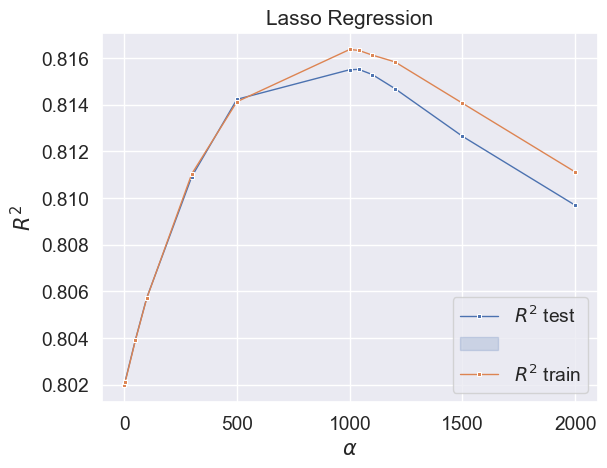

In [338]:
print(f"Best alpha for Lasso regression is {alpha_lasso}")
p = BestParameters("Lasso Regression", k, alpha_lasso, {}, 0.0, scores_lasso)
parameters.append(p)
plot_scores(p.scores, "$\\alpha$", "$R^2$")  # serve doppia \\ per scrivere \alpha
plot_scores(p.scores, "$\\alpha$", "$R^2$", idx_x=0, idx_y=2)
plt.legend(labels=["$R^2$ test", "", "$R^2$ train"])

Adesso eseguiamo la predizione sul test set con la cross validation con i migliori parametri:

In [312]:
# usiamo i migliori parametri per eseguire la valutazione sui test set in cross validation
lasso_regression = Lasso(alpha=alpha_lasso, tol=0.1)
mean_r2_lasso = our_cross_validation_test(folds, lasso_regression, k)
p.r2 = mean_r2_lasso
print(f"mean r2 for lasso: {mean_r2_lasso}")

mean r2 for lasso: 0.8198262406677694


## 6.4 Ridge Regression
La ridge regression usa un coefficiente di regolarizzazione $\alpha$ per ridurre la complessità del modello e quindi l'overfitting, il che potrebbe essere utile in quanto abbiamo pochi elementi nel dataset (1480).

In [313]:
def ridge_regression_cv(x_train: DataFrame, y_train: Series, alpha=1.0, scaled=False) -> Tuple[float, Any]:
    model = Ridge(alpha=alpha, random_state=42)
    val_folds = split_dataset(x_train, y_train, splits=10)
    r2 = our_cross_validation_test(val_folds, model,
                                   scaled=scaled)
    return r2, model


# Esempio con e senza FS / Normalizzazione
print("r2 initial without feature selection", ridge_regression_cv(folds[0].X_train, folds[0].y_train)[0])
print("r2 initial with feature selection", ridge_regression_cv(fs_X_train, folds[0].y_train)[0])
print("r2 normalized without feature selection", ridge_regression_cv(folds[0].X_train_normalized, folds[0].y_train)[0])
print("r2 normalized with feature selection", ridge_regression_cv(fs_X_train_normalized, folds[0].y_train)[0])

r2 initial without feature selection 0.7911522624456518
r2 initial with feature selection 0.7252837045471626
r2 normalized without feature selection 0.7726401939928482
r2 normalized with feature selection 0.72533192391834


Sia il training set originale che normalizzato risultano essere migliori senza feature selection.

Determiniamo il miglior valore di *alpha* per la regressione Ridge:

In [314]:
def best_alpha_ridge(folds: List[Fold], k_features=104, scaled=True):
    scores = []
    best_alpha = 0
    best_r2 = 0.0
    #alphas = list(np.linspace(0.5, 20, 20))
    alphas = [1, 20, 50, 100, 110, 139, 170, 200]

    # eseguiamo la feature selection su tutti i fold e manteniamola in memoria, per ridurre il tempo di esecuzione totale
    folds = do_fs_for_each_fold(folds, k_features)

    # poi eseguiamo la model selection per trovare il migliore alpha
    for a in alphas:
        r2_score_cv_sum = 0.0
        r2_score_sum = 0.0
        for f in folds:
            r2_score_cv, model = ridge_regression_cv(f.X_train_normalized_fs, f.y_train, a, scaled=scaled)
            r2_score_cv_sum += r2_score_cv
            r2_score_sum += model.score(f.X_test_normalized_fs, f.y_test)

        r2_score_cv = r2_score_cv_sum / len(folds)
        r2_score = r2_score_sum / len(folds)
        print(f"Ridge alpha = {a:.4f} - k={k} - r2_cv = {r2_score_cv:.6f} - r2 = {r2_score:.6f}")
        scores.append((a, r2_score, r2_score_cv))
        if r2_score > best_r2:
            best_r2 = r2_score
            best_alpha = a
    return best_alpha, scores


alpha_ridge, scores_ridge = best_alpha_ridge(folds, k)
#print("Ridge without normalization")
#alpha_ridge_no_scaled, scores_ridge_no_scaled = best_alpha_ridge(folds, k, scaled=False)

Feature selection... Done
Ridge alpha = 1.0000 - k=104 - r2_cv = 0.812267 - r2 = 0.811271
Ridge alpha = 20.0000 - k=104 - r2_cv = 0.816662 - r2 = 0.816476
Ridge alpha = 50.0000 - k=104 - r2_cv = 0.818733 - r2 = 0.818668
Ridge alpha = 100.0000 - k=104 - r2_cv = 0.819813 - r2 = 0.819800
Ridge alpha = 110.0000 - k=104 - r2_cv = 0.819873 - r2 = 0.819873
Ridge alpha = 139.0000 - k=104 - r2_cv = 0.819881 - r2 = 0.819920
Ridge alpha = 170.0000 - k=104 - r2_cv = 0.819685 - r2 = 0.819767
Ridge alpha = 200.0000 - k=104 - r2_cv = 0.819356 - r2 = 0.819476


Best alpha for Ridge regression is 139


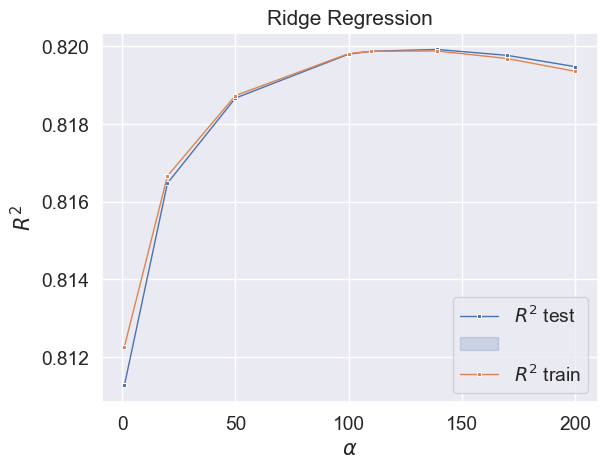

In [339]:
print(f"Best alpha for Ridge regression is {alpha_ridge}")
p = BestParameters("Ridge Regression", k, alpha_ridge, {}, 0.0, scores_ridge)
parameters.append(p)
plot_scores(p.scores, "$\\alpha$", "$R^2$")
plot_scores(p.scores, "$\\alpha$", "$R^2$", idx_x=0, idx_y=2)
plt.legend(labels=["$R^2$ test", "", "$R^2$ train"])

Utilizziamo il miglior parametro di *alpha* e *k* per eseguire a valutazione sui test set con la cross validation:

In [316]:
ridge_regression = Ridge(alpha=alpha_ridge)
mean_r2_ridge = our_cross_validation_test(folds, ridge_regression, k)
p.r2 = mean_r2_ridge
print(f"mean r2 for ridge: {mean_r2_ridge}")

mean r2 for ridge: 0.8274649291937136


La *regressione Ridge* risulta essere migliore della *regressione Lasso*.

## 6.5 ElasticNET Regression

L''Elastic-Net' è un metodo di regressione regolarizzato che combina linearmente le due penalità, *L1* e *L2*, dei metodi di regressione Lasso e Ridge.
- *'l1_ratio'*: determina la percentuale della nostra penalità L1 rispetto a $\alpha$. Quindi, per esempio, se $\alpha = 1$ e $L1_{ratio}$ = 0.4, la nostra penalità $L1$ sarà moltiplicata per 0.4 e la nostra penalità $L2$ sarà moltiplicata per $1 - L1_{ratio} = 0.6$

In questo caso abbiamo la regressione ridge se $L1_{ratio} = 0$ e la regressione lasso se $L1_{ratio} = 1$.

La proprietà più importante di Lasso è che produce pesi del modello sparsi, il che significa che i pesi possono essere impostati fino a 0.



In [317]:
from sklearn.linear_model import ElasticNet, Lasso


def elastic_net_cv(x_train: DataFrame, y_train: Series, alpha=0.1, l1_ratio=0.5, scaled=True) -> Tuple[float, Any]:
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, tol=0.4, random_state=42)
    val_folds = split_dataset(x_train, y_train, splits=10)
    r2 = our_cross_validation_test(val_folds, model,
                                   scaled=scaled)
    return r2, model


# Esempio con e senza FS / Normalizzazione
print("r2 initial without feature selection", elastic_net_cv(folds[0].X_train, folds[0].y_train, scaled=False)[0])
print("r2 initial with feature selection", elastic_net_cv(fs_X_train, folds[0].y_train, scaled=False)[0])
print("r2 normalized without feature selection", elastic_net_cv(folds[0].X_train_normalized, folds[0].y_train)[0])
print("r2 normalized with feature selection", elastic_net_cv(fs_X_train_normalized, folds[0].y_train)[0])

r2 initial without feature selection 0.7109594919379452
r2 initial with feature selection 0.7162289134035058
r2 normalized without feature selection 0.7260032529974604
r2 normalized with feature selection 0.7403388295574751


Risulta essere migliore il training set con feature selection.

Proviamo a determinare il miglior valore di *alpha* e *l1_ratio* tramite *GridSearch* solo sul fold[0]:

In [341]:
from sklearn.model_selection import GridSearchCV
from numpy import arange


def grid_search_elastic_net(folds: List[Fold], k_features=104, with_fs=True):
    param_grid = {
        'alpha': list(np.linspace(0.1, 3, 10)),
        'l1_ratio': arange(0, 1, 0.1),
        'tol': [0.4, 0.5]
    }

    x_train_fs = mutual_info_feature_selection(folds[0].X_train_normalized, folds[0].y_train,
                                               k_features) if with_fs else f.X_train_normalized

    eNet = ElasticNet()

    grid_search = GridSearchCV(eNet, param_grid, scoring='r2', cv=10)
    grid_search.fit(x_train_fs, folds[0].y_train)
    r2_score = grid_search.best_score_
    best_param = grid_search.best_params_
    print(f"Lasso alpha = {best_param}  - r2 = {r2_score} ")
    return best_param


best_param_gs_elastic_net = grid_search_elastic_net(folds, k)

Lasso alpha = {'alpha': 1.3888888888888888, 'l1_ratio': 0.7000000000000001, 'tol': 0.5}  - r2 = 0.795147793439807 


Determiniamo il miglior valore di *alpha* e *l1_ratio*:

In [342]:
def best_param_elastic_net(folds: List[Fold], k_features=104, scaled=True):
    scores = []
    best_alpha = 0
    best_l1 = 0
    best_r2 = 0.0
    alphas = list(np.linspace(0.1, 3, 10))
    l1s = arange(0.1, 1, 0.1)

    # eseguiamo la feature selection su tutti i fold e manteniamola in memoria, per ridurre il tempo di esecuzione totale
    folds = do_fs_for_each_fold(folds, k_features)

    # poi eseguiamo la model selection per trovare il migliore alpha e il miglior L1 ratio
    for a in alphas:
        for l1 in l1s:
            r2_score_cv_sum = 0.0
            r2_score_sum = 0.0
            for f in folds:
                r2_score_cv, model = elastic_net_cv(f.X_train_normalized_fs, f.y_train, a, l1, scaled=scaled)
                r2_score_cv_sum += r2_score_cv
                r2_score_sum += model.score(f.X_test_normalized_fs, f.y_test)
            r2_score_cv = r2_score_cv_sum / len(folds)
            r2_score = r2_score_sum / len(folds)
            print(
                f"Elastic net alpha = {a:.4f} - k={k} - l1-ratio = {l1:.1f} r2_cv = {r2_score_cv:.6f} - r2 = {r2_score:.6f} ")
            scores.append((a, l1, r2_score, r2_score_cv))
            if r2_score > best_r2:
                best_r2 = r2_score
                best_alpha = a
                best_l1 = l1
    return best_alpha, best_l1, scores


alpha_elastic_net, l1_elastic_net, scores_elastic_net = best_param_elastic_net(folds, k)
#print("ElasticNet without normalization")
#alpha_elastic_net, l1_elastic_net, scores_elastic_net = best_param_elastic_net(folds, k, scaled=False)

Feature selection... Done
Elastic net alpha = 0.1000 - k=104 - l1-ratio = 0.1 r2_cv = 0.760285 - r2 = 0.761276 
Elastic net alpha = 0.1000 - k=104 - l1-ratio = 0.2 r2_cv = 0.757960 - r2 = 0.758973 
Elastic net alpha = 0.1000 - k=104 - l1-ratio = 0.3 r2_cv = 0.755518 - r2 = 0.756555 
Elastic net alpha = 0.1000 - k=104 - l1-ratio = 0.4 r2_cv = 0.752951 - r2 = 0.754014 
Elastic net alpha = 0.1000 - k=104 - l1-ratio = 0.5 r2_cv = 0.750251 - r2 = 0.751342 
Elastic net alpha = 0.1000 - k=104 - l1-ratio = 0.6 r2_cv = 0.747412 - r2 = 0.748531 
Elastic net alpha = 0.1000 - k=104 - l1-ratio = 0.7 r2_cv = 0.744423 - r2 = 0.745573 
Elastic net alpha = 0.1000 - k=104 - l1-ratio = 0.8 r2_cv = 0.741275 - r2 = 0.742457 
Elastic net alpha = 0.1000 - k=104 - l1-ratio = 0.9 r2_cv = 0.737957 - r2 = 0.739174 
Elastic net alpha = 0.4222 - k=104 - l1-ratio = 0.1 r2_cv = 0.806606 - r2 = 0.806993 
Elastic net alpha = 0.4222 - k=104 - l1-ratio = 0.2 r2_cv = 0.805148 - r2 = 0.803242 
Elastic net alpha = 0.4222 -

Best alpha for Elastic net is 0.7444444444444444
Best l1 for Elastic net is 0.5


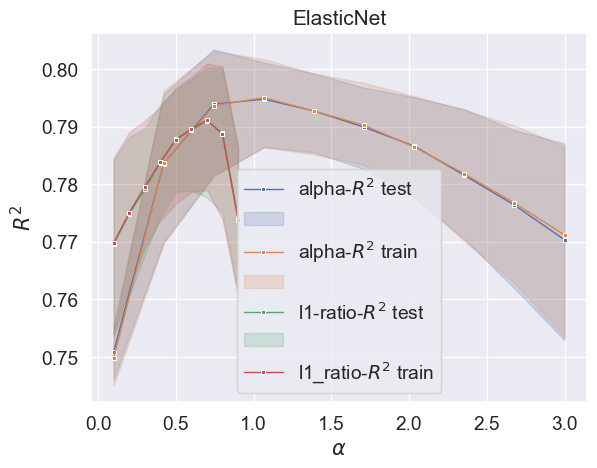

In [343]:
print(f"Best alpha for Elastic net is {alpha_elastic_net}")
print(f"Best l1 for Elastic net is {l1_elastic_net}")

p = BestParameters("ElasticNet", k, alpha_elastic_net, {'l1_ratio': l1_elastic_net}, 0.0, scores_elastic_net)
parameters.append(p)
plot_scores(p.scores, "$\\alpha$", "$R^2$", idx_x=0, idx_y=2)
plot_scores(p.scores, "$\\alpha$", "$R^2$", idx_x=0, idx_y=3)
plot_scores(p.scores, "l1-ratio", "$R^2$", idx_x=1, idx_y=2)
plot_scores(p.scores, "l1-ratio", "$R^2$", idx_x=1, idx_y=3)
plt.legend(labels=["alpha-$R^2$ test", "", "alpha-$R^2$ train", "", "l1-ratio-$R^2$ test", "", "l1_ratio-$R^2$ train"])

In [344]:
elastic_net = ElasticNet(alpha=alpha_elastic_net, l1_ratio=l1_elastic_net, random_state=42)
mean_r2_elastic_net = our_cross_validation_test(folds, elastic_net, k)
p.r2 = mean_r2_elastic_net
print(f"mean r2 for lasso: {mean_r2_elastic_net}")

mean r2 for lasso: 0.823699161273006


## 6.6 SVM Regression

Per la regressione SVM, utilizziamo la classe SVR e in particolare selezioniamo i migliori parametri tra i seguenti:

- **Cfloat**: default=1.0. Parametro di regolarizzazione. La forza della regolarizzazione è inversamente proporzionale a C. Deve essere strettamente positivo. La funzione costo è L2.

- **kernel**: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’. Specifica il tipo di funzione kernel da usare nell'algoritmo. 

- **degree**: int, default=3. Grado del polinomio se il kernel è polinomiale. Deve essere non negativo. Viene ignorato da gli altri tipi di kernel diversi da 'poly'.

- **gamma**: {‘scale’, ‘auto’} or float, default=’scale’. Coefficiente Kernel per ‘rbf’, ‘poly’ and ‘sigmoid’.
    - se gamma='scale' (default) $gamma := 1 / (n_{features} * X.var())$,
    - se ‘auto’, $gamma := 1 / n_{features}$
    - se float, $gamma \geq 0$.


In [ ]:
def svr_cv(X_train_normalized_fs: DataFrame, y_train: Series, svm: SVR) -> float:
    return cross_val_score(svm, X_train_normalized_fs, y_train, cv=10, scoring='r2', error_score='raise').mean()


def svr_score(X_train_normalized_fs: DataFrame, y_train: Series, X_test_normalized_fs: DataFrame, y_test: Series,
              svm: SVR) -> float:
    svm.fit(X_train_normalized_fs, y_train)
    return svm.score(X_test_normalized_fs, y_test)

In [ ]:
# classe per mantenere ordinati i parametri di SVR
class SVRParams:
    def __init__(self, C: float, kernel: str, poly_degree: int, gamma: str | float, max_iter: int) -> None:
        self.C = C
        self.kernel = kernel
        self.poly_degree = poly_degree
        self.gamma = gamma
        self.max_iter = max_iter

    def __str__(self):
        return f"C : {self.C:.2f}, kernel : {self.kernel}, poly_degree : {self.poly_degree}, gamma : {self.gamma:.2f}, max_iter : {self.max_iter}"

    def __repr__(self) -> str:
        return self.__str__()

    def default():
        return SVRParams(1, 'rbf', 0, 1, -1)

    def create_svr(self):
        return SVR(C=self.C, kernel=self.kernel, degree=self.poly_degree, gamma=self.gamma, max_iter=self.max_iter,
                   tol=0.01)

    def to_array(self, r2: float, r2_test: float):
        return [self.C, self.kernel, self.poly_degree, self.gamma, self.max_iter, r2, r2_test]


def run_svr(params: SVRParams, folds: List[Fold], scores, curr_iter, total_iterations) -> float:
    # creo il modello dai parametri scelti (mio metodo di utilita')
    svm = params.create_svr()
    r2_score_cv_sum = 0.0
    r2_score_sum = 0.0
    for f in folds:
        r2_score_cv_sum += svr_cv(f.X_train_normalized_fs, f.y_train, svm)
        r2_score_sum += svr_score(f.X_train_normalized_fs, f.y_train, f.X_test_normalized_fs, f.y_test, svm)
    r2_score_cv = r2_score_cv_sum / len(folds)
    r2_score = r2_score_sum / len(folds)

    # aggiungo al dataframe i parametri appena usati e il punteggio.
    new_row_df = pd.DataFrame([params.to_array(r2_score_cv, r2_score)],
                              columns=["C", "kernel", "poly_degree", "gamma", 'max_iter', 'r2', 'r2_test'])
    scores = pd.concat([scores, new_row_df], axis=0)

    print(f"{curr_iter} of {total_iterations} - PARAMS [{params}] - R2: {r2_score_cv:.6f} - R2 Test: {r2_score_cv:.6f}")
    return r2_score


# metodo che trova i migliori parametri di SVR
def find_best_svr_params(folds: List[Fold], k_features=129) -> Tuple[pd.DataFrame, Tuple[SVRParams, float]]:
    # questi sono i parametri su cui facciamo grid search
    C_values = [0.1, 0.5, 1, 1.5, 2]
    kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
    poly_degree_values = [2, 3, 4]
    gamma_values = [0.1, 1, 4]
    max_iter = -1  # TODO: non va bene 10000, forse va aggiuta la tol! -1 neanche: sembra non finire mai.

    # assegno i tipi numpy e poi trasformo in dataframe
    dtypes = np.dtype(
        [
            ("C", float),
            ("kernel", str),
            ("poly_degree", int),
            ("gamma", float),
            ('max_iter', int),
            ('r2', float),
            ('r2_test', float)
        ]
    )
    # calcolo il numero di giri da fare in totale:
    total_iterations = (len(C_values) * len(gamma_values)) * (len(poly_degree_values) + len(kernel_values) - 1)
    curr_iter = 0

    # eseguiamo la feature selection su tutti i fold e manteniamola in memoria, per ridurre il tempo di esecuzione totale
    folds = do_fs_for_each_fold(folds, k_features)

    # poi eseguiamo la model selection per trovare il migliore alpha e il miglior L1 ratio

    scores: pd.DataFrame[float, str, int, float, int, float, float] = pd.DataFrame(np.empty(0, dtype=dtypes))
    best_score_params: Tuple[SVRParams, float] = None
    best_r2 = 0.0
    for c in C_values:
        for kernel in kernel_values:
            for gamma in gamma_values:
                if kernel == 'poly':
                    for poly_degree in poly_degree_values:
                        curr_iter += 1
                        # metto insieme i parametri nella classe, per comodita'
                        params = SVRParams(c, kernel, poly_degree, gamma, max_iter)
                        r2_score = run_svr(params, folds, scores, curr_iter, total_iterations)
                        if r2_score > best_r2:
                            best_r2 = r2_score
                            best_score_params = (params, r2_score)

                else:
                    curr_iter += 1
                    # metto insieme i parametri nella classe, per comodita'. Il degree e' sempre 0
                    params = SVRParams(c, kernel, 0, gamma, max_iter)
                    r2_score = run_svr(params, folds, scores, curr_iter, total_iterations)
                    if r2_score > best_r2:
                        best_r2 = r2_score
                        best_score_params = (params, r2_score)

    return scores, best_score_params

In [ ]:
scores, best_score_params = find_best_svr_params(folds)

print(f"The BESTEST model is: {best_score_params}")
print(scores)

## 6.9 KNN
Metodo parametrico

## 6.7 Kernel Regression (Nadaraya Watson)
Metodo parametrico

## 6.8 Decision Tree
Metodo parametrico ?

## 6.8 LOESS Regression
Metodo misto parametrico e non.

## 6.10 Reti neurali

# 7. Bagging and Boosting

# 8. Conclusione

In [ ]:
for param in parameters:
    if param.print_parameters() is not None:
        print(param.print_parameters())